# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Данные находятся в файле */datasets/autos.csv.* 

**Признаки**
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**
- *Price* — цена (евро)

## Подготовка данных

#### Загрузка библиотек

In [5]:
!pip install sweetviz -q
import sweetviz as sv

In [6]:
import time
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from numpy.random import RandomState
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoost, CatBoostRegressor, Pool
import lightgbm  as lgb
from lightgbm import LGBMRegressor

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
%matplotlib inline

#### Загрузка данных

In [8]:
try:
    df_autos = pd.read_csv('/datasets/autos.csv')
except:
    df_autos = pd.read_csv('F:/autos.csv')

In [9]:
df_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Переименуем столбцы датасета согласно PEP8

In [11]:
df_autos.rename(columns={'DateCrawled': 'date_crawled', 
                         'Price': 'price_euro',
                         'VehicleType': 'vehicle_type',
                         'RegistrationYear': 'reg_year',
                         'Gearbox': 'gearbox',
                         'Power': 'power',
                         'Model': 'model',
                         'Kilometer': 'kilometer',
                         'RegistrationMonth': 'reg_month',
                         'FuelType': 'fuel_type',
                         'Brand': 'brand',
                         'NotRepaired': 'not_repaired',
                         'DateCreated': 'date_created',
                         'NumberOfPictures': 'num_photo',
                         'PostalCode': 'zip_code',
                         'LastSeen': 'last_seen'
                        }, inplace=True)

#### Анализ данных

                                             |          | [  0%]   00:00 -> (? left)


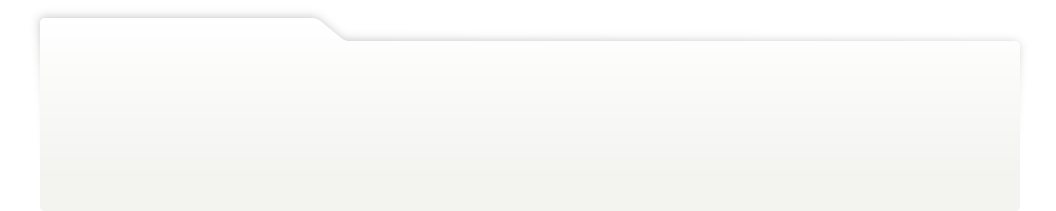
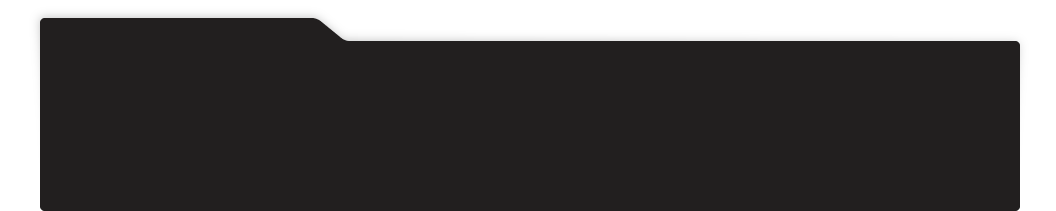
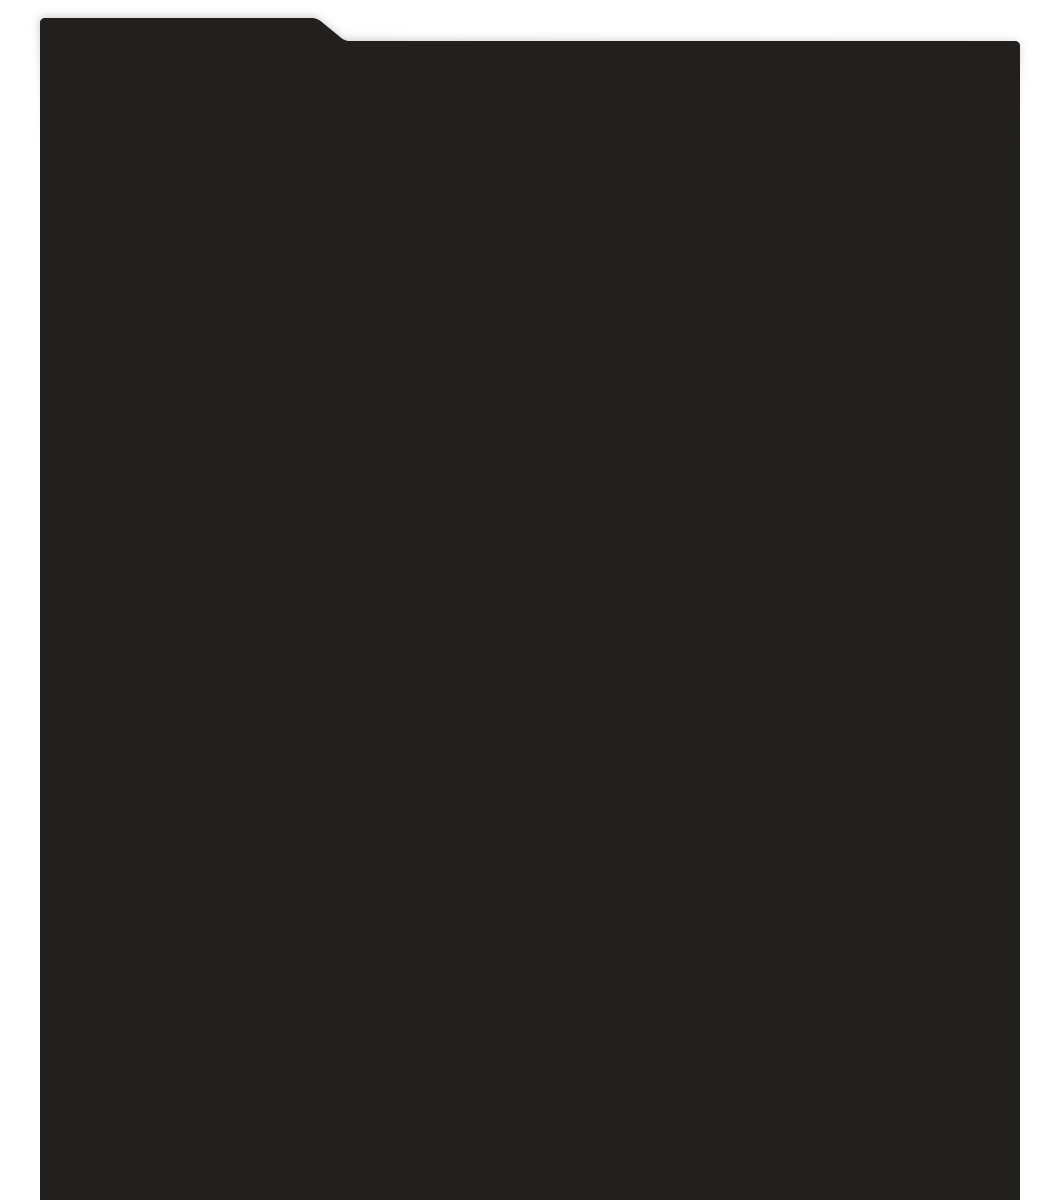
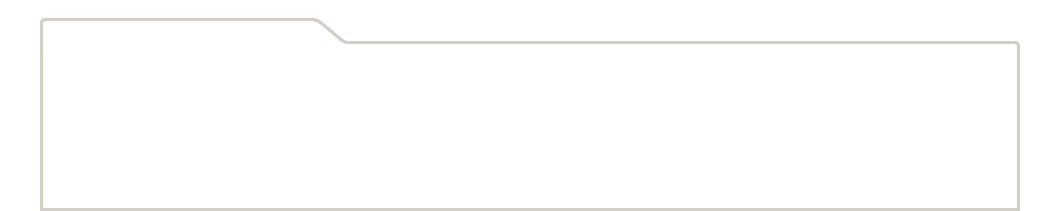
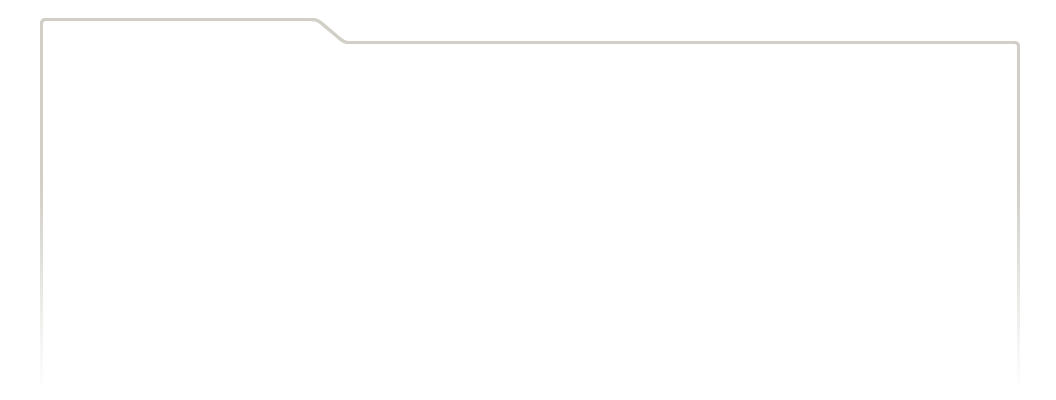
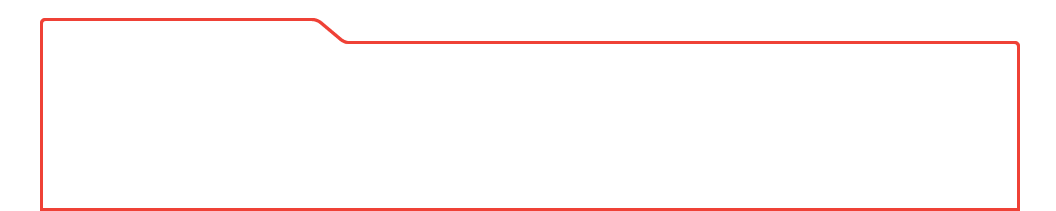
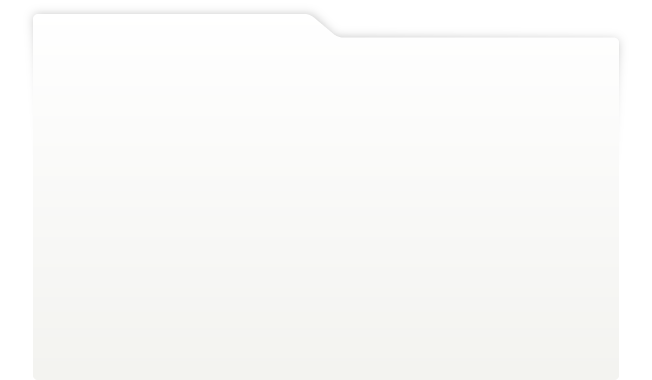
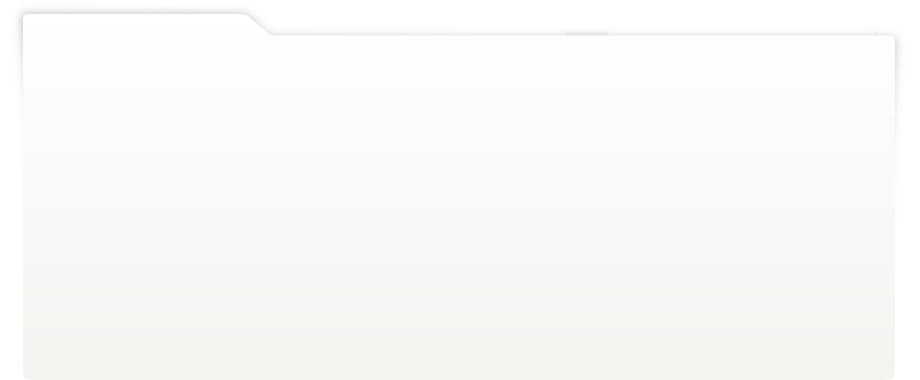
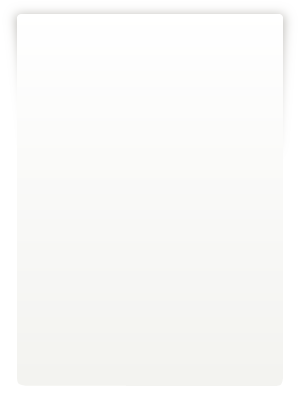
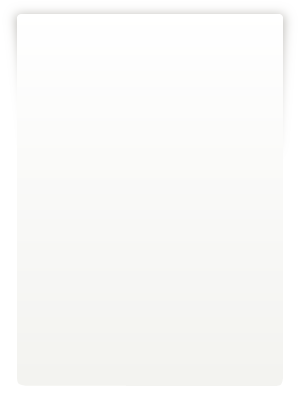
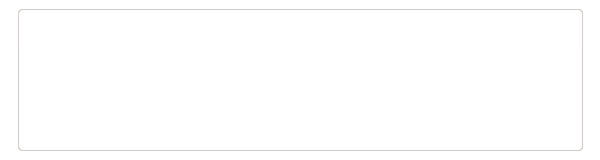
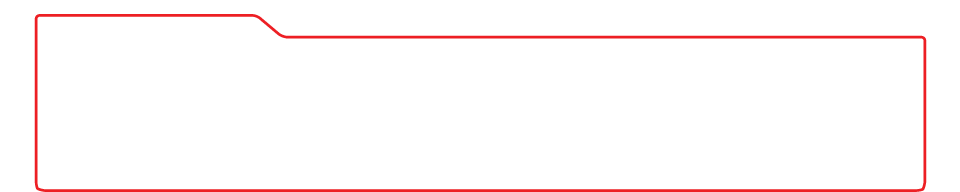
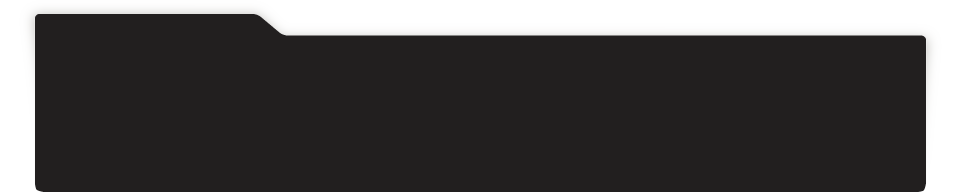
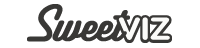
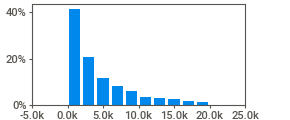
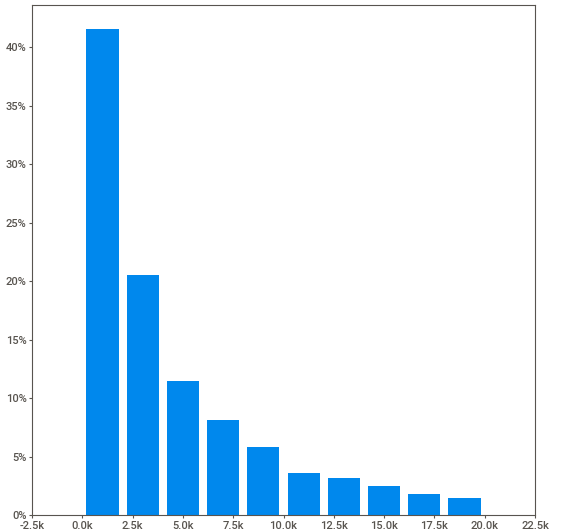
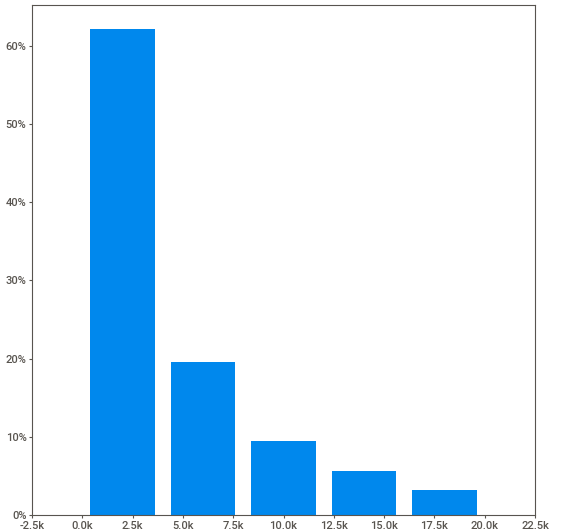
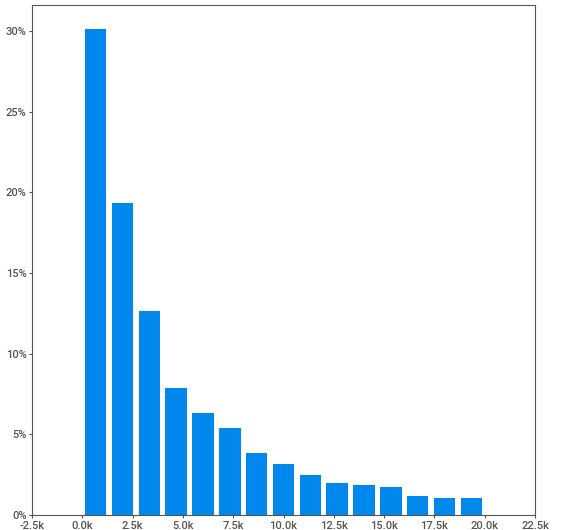
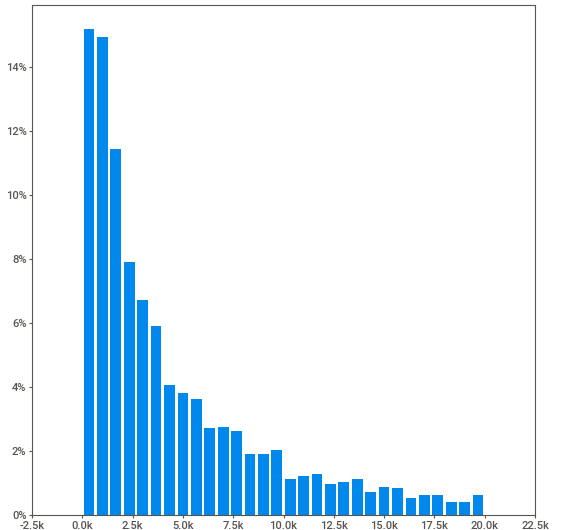
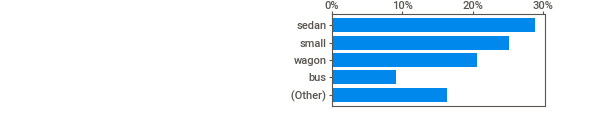
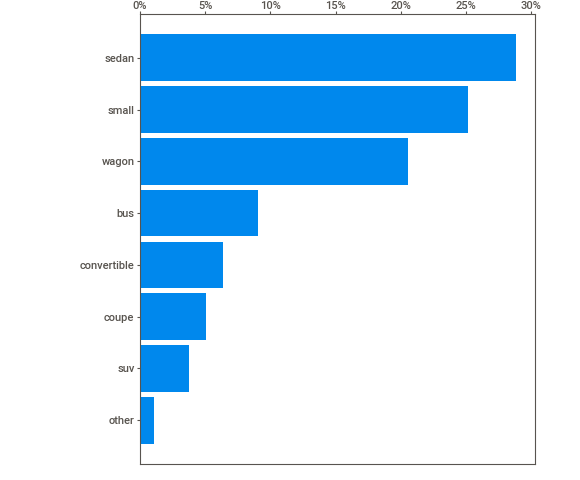
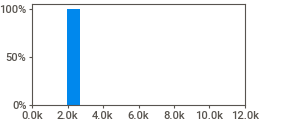
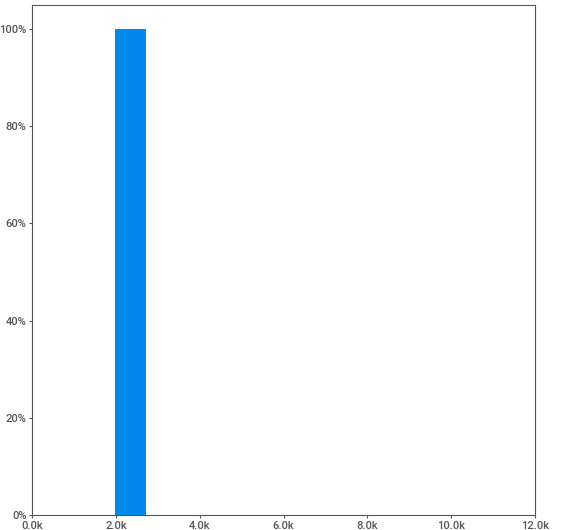
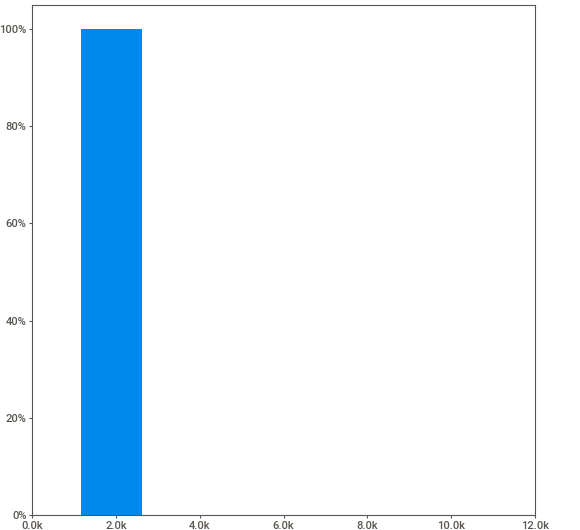
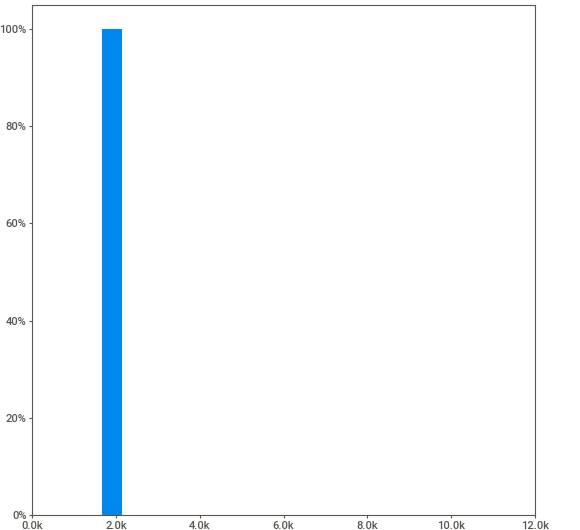
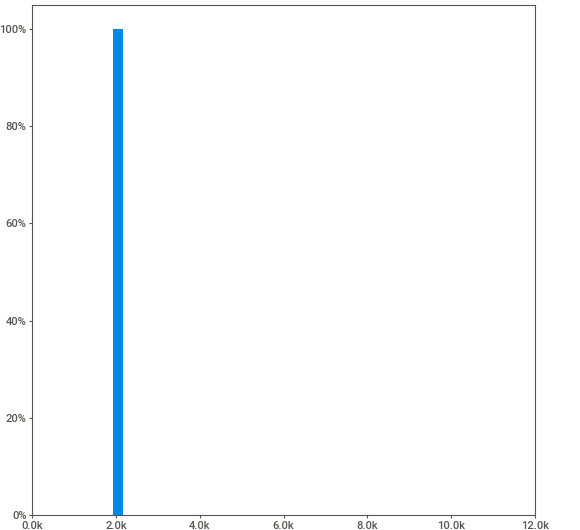
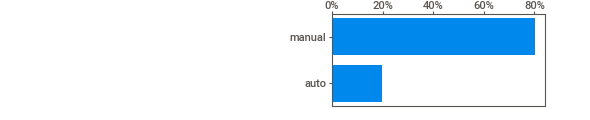
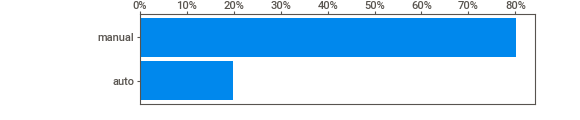
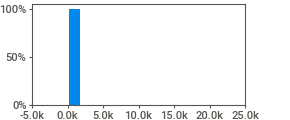
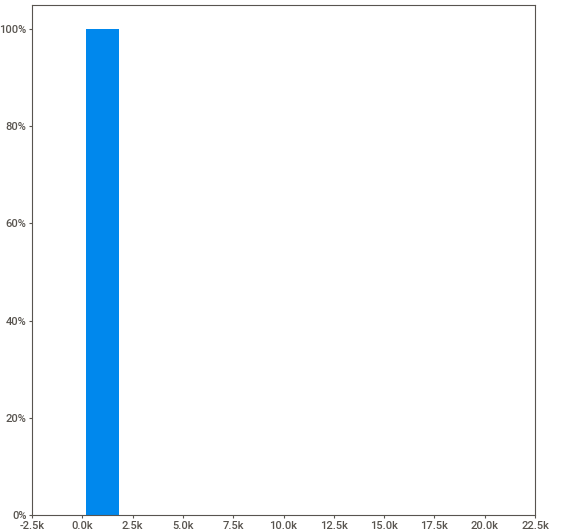
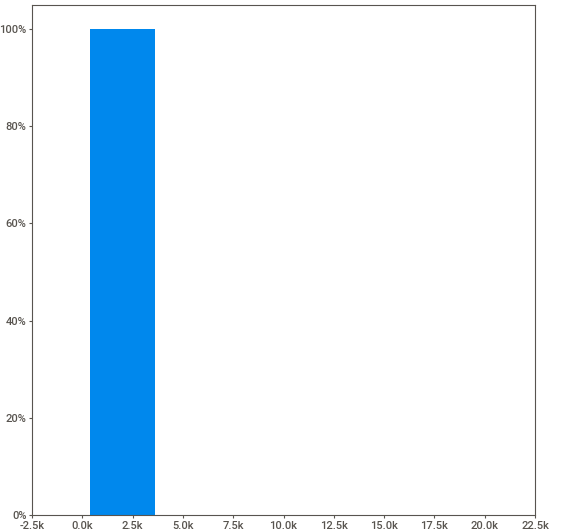
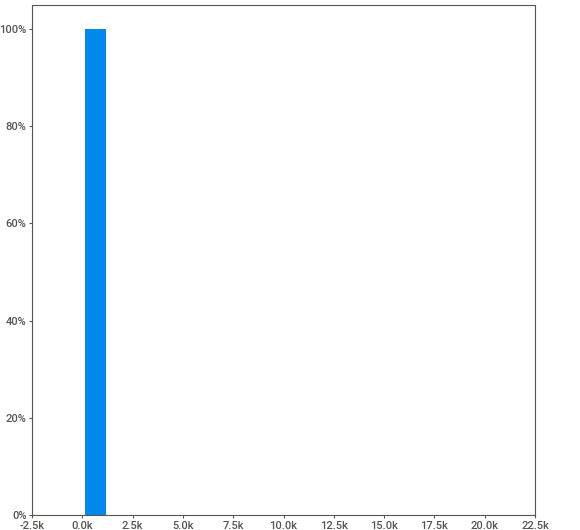
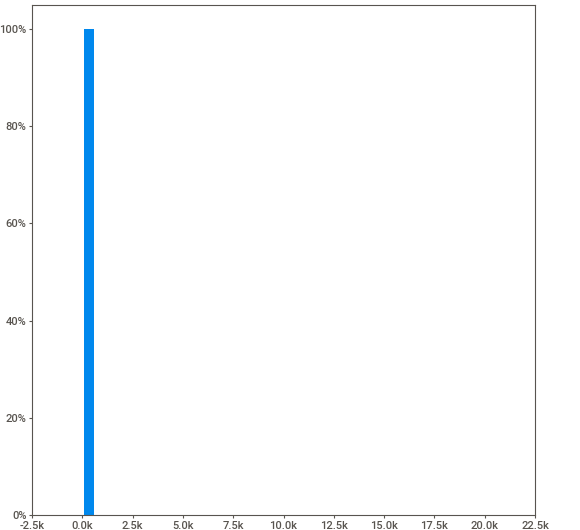
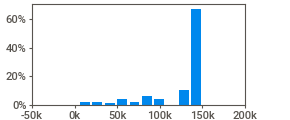
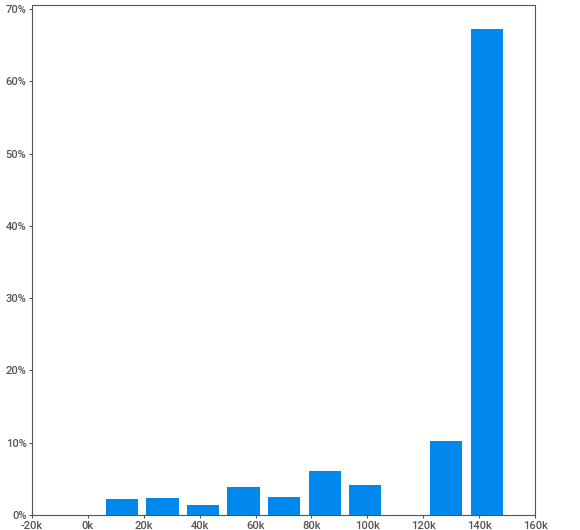
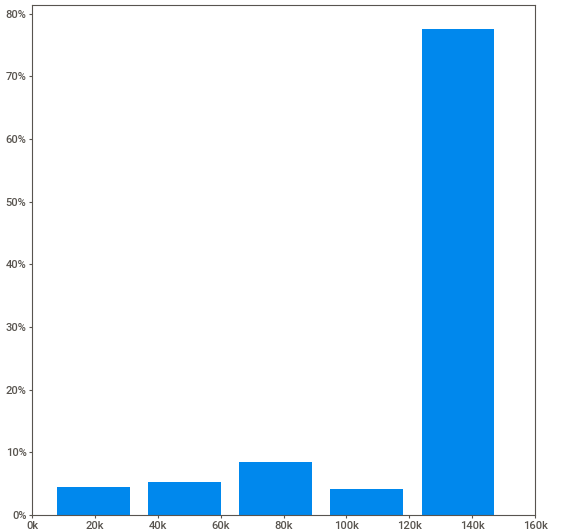
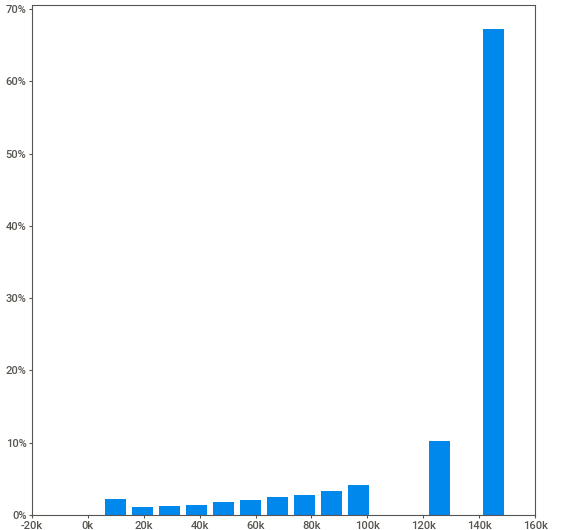
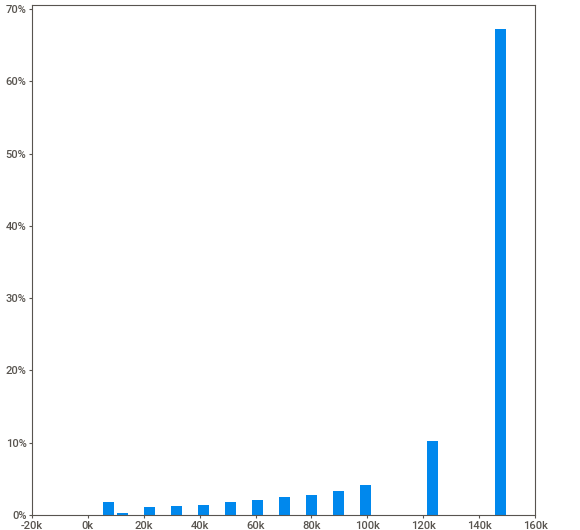
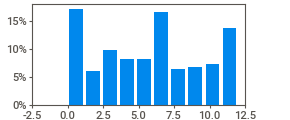
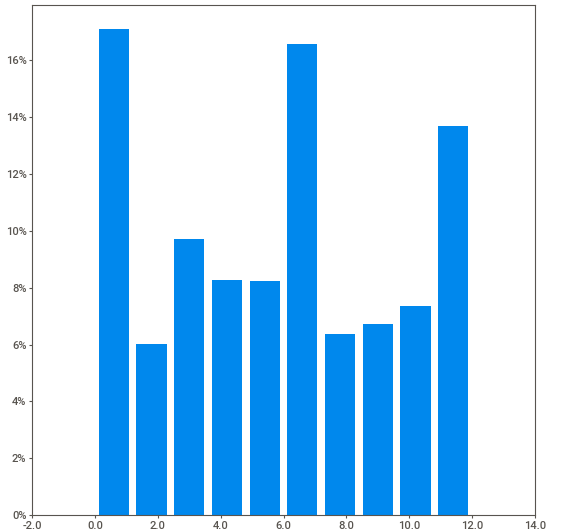
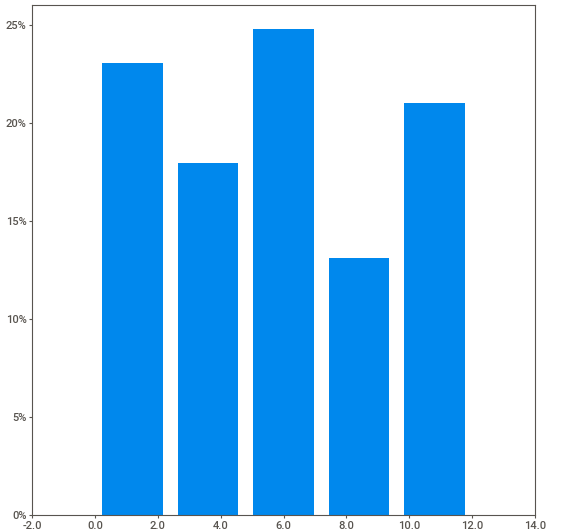
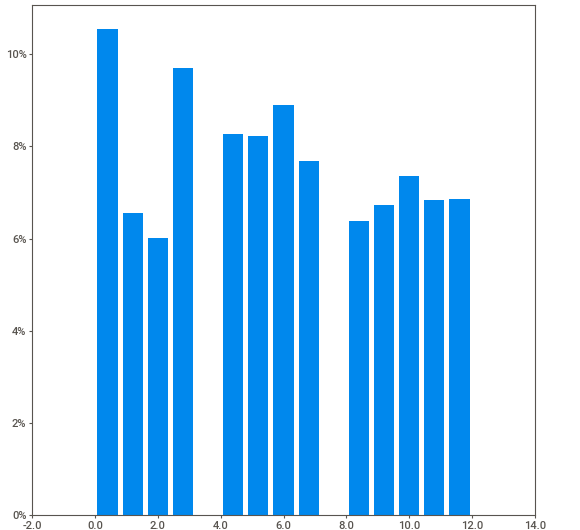
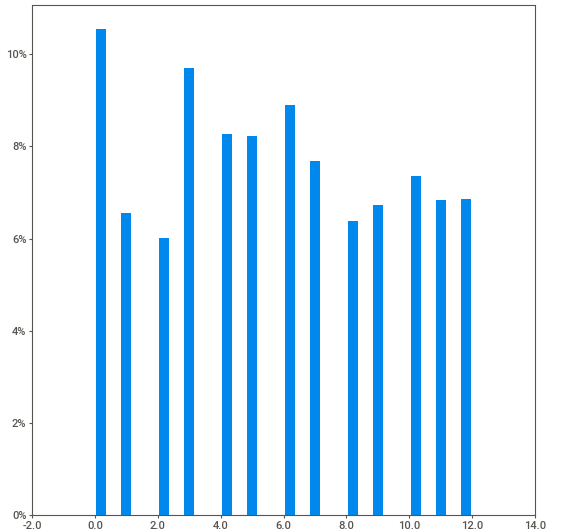
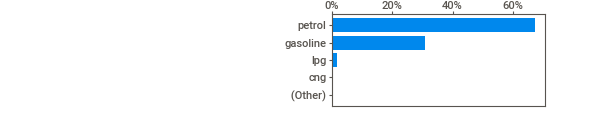
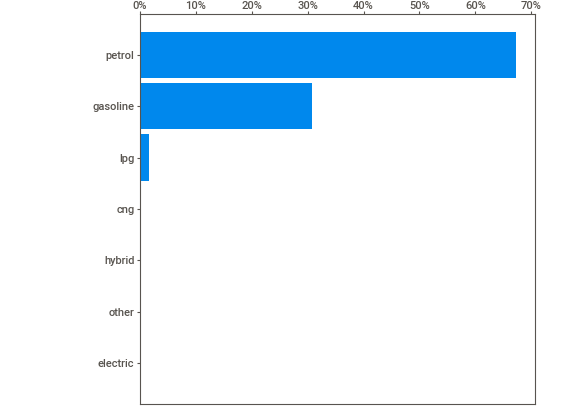
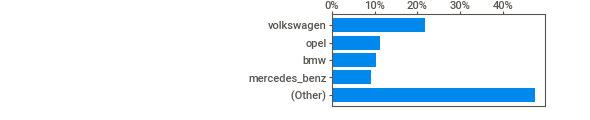
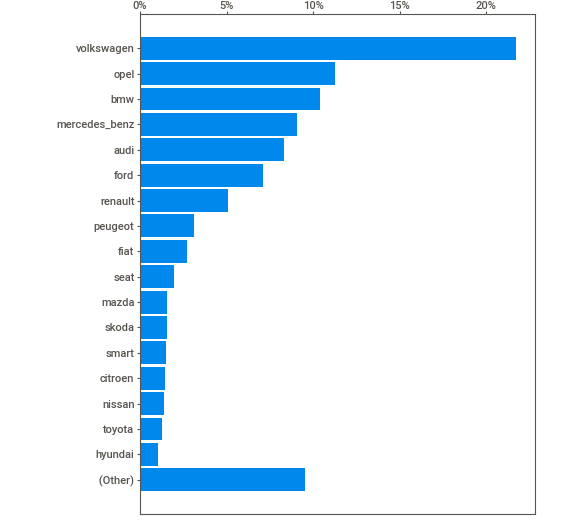
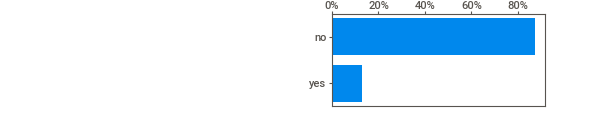
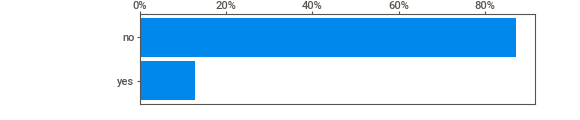
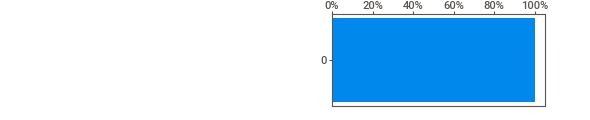
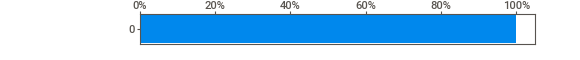
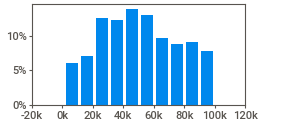
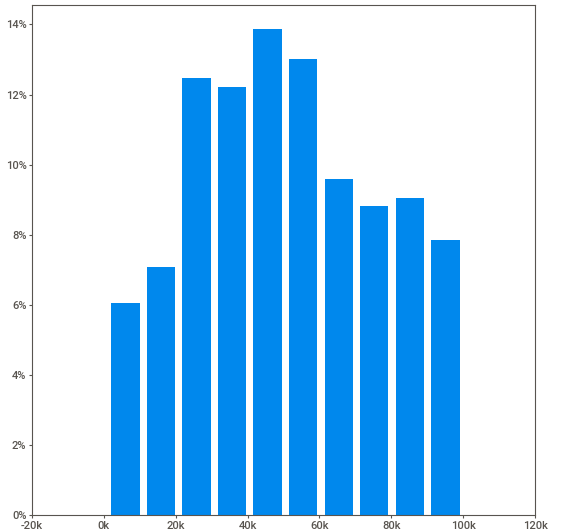
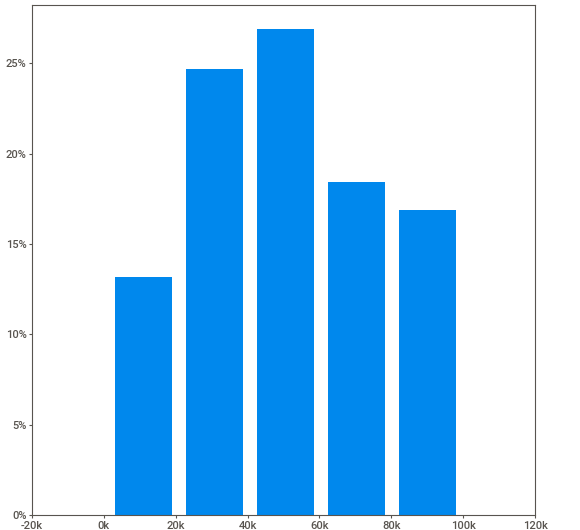
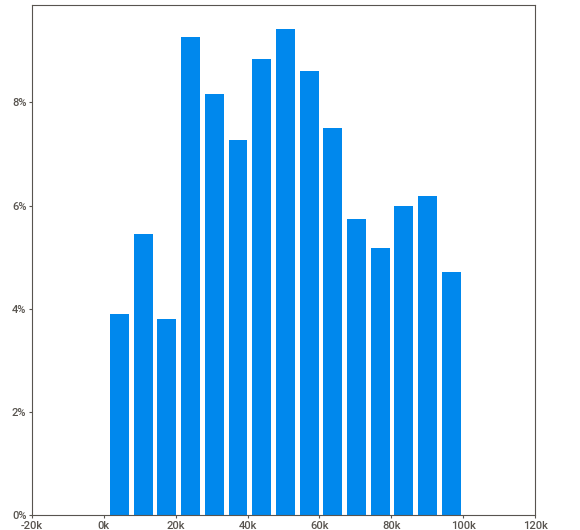
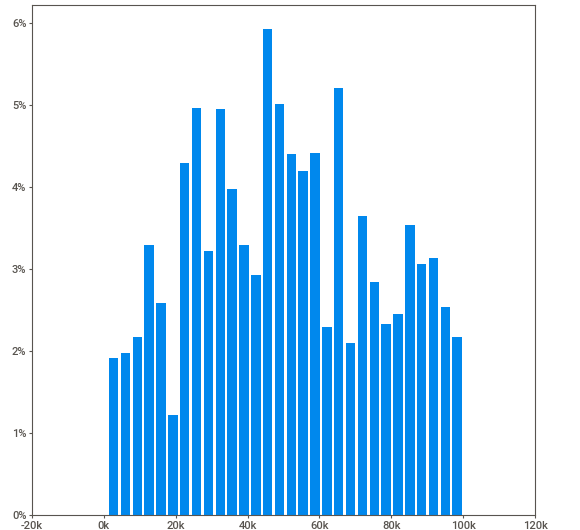
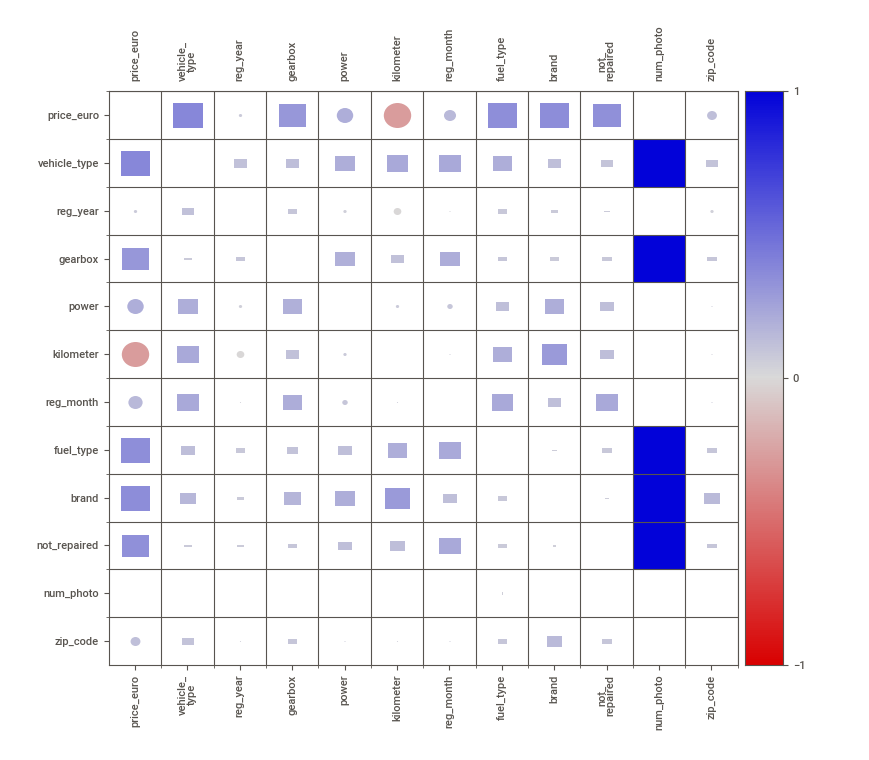
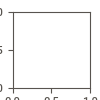

In [10]:
report_df_autos = sv.analyze([df_autos, 'Автомобили и цены'], pairwise_analysis='on')
report_df_autos.show_notebook(w='100%', h='full', scale=None, filepath=None)

#### Предобработка данных

Вследствие заполненности признака num_photo одними нулями, следует удалить этот признак как лишний

In [12]:
df_autos.drop('num_photo', axis=1, inplace=True)

У временных признаков следует ограничить время датами

In [13]:
df_autos['date_crawled'] = df_autos['date_crawled'].apply(lambda x: x[:10])
df_autos['date_created'] = df_autos['date_created'].apply(lambda x: x[:10])
df_autos['last_seen'] = df_autos['last_seen'].apply(lambda x: x[:10])

Судя по встречающимся немецким термином sonstige_autos в бренде авто, означающим "другое авто", похоже, что датасет с немецкими регионами. А 4-значных значениях пропущен 0 впереди. Первые две цифры в почтовых индексах Германии - обозначение региона. Таким образом можно получить признак region.

In [14]:
df_autos['region'] = df_autos['zip_code'].apply(lambda x: x // 1000)
df_autos['region'].unique()

array([70, 66, 90, 91, 60, 33, 67, 19, 94, 27, 96, 57, 37,  4, 24, 38, 65,
       88, 49, 75, 68,  9, 35, 73, 31, 12, 87, 86, 53, 44, 39,  2, 46, 10,
       22, 56, 59, 21, 84, 48, 34, 71, 23,  6,  1, 63, 55, 85, 47,  8, 79,
       83, 41, 32, 26, 78, 45, 29, 51, 40, 30, 74, 97, 13, 61, 82, 42, 28,
       77, 72, 89, 16, 99, 15, 95, 17, 64, 76, 25, 52, 14, 50, 93, 36, 54,
       58, 80, 81,  7, 18, 20,  3, 92, 69, 98])

Создаем признак периода активности объявления в днях

In [15]:
df_autos['active_period'] = (pd.to_datetime(df_autos['last_seen']) - pd.to_datetime(df_autos['date_created'])).dt.days
df_autos['active_period'].value_counts()

0      50589
2      38279
4      26534
1      21358
6      19991
       ...  
94         1
96         1
97         1
98         1
759        1
Name: active_period, Length: 109, dtype: int64

Создаем признак месяца подачи объявления

In [16]:
df_autos['month_created'] = pd.to_datetime(df_autos['date_created']).dt.month
df_autos['month_created'].value_counts()

3     296759
4      57119
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: month_created, dtype: int64

Избавимся от пропусков в датасете. Пропуски только в категориальных признаках. Их можно заполнить лейблом 'missing' или после перевода в числа пометить числом -1

In [17]:
df_autos.fillna('missing', inplace=True)

Избавимся от явных выбросов-аномалий в признаке power

In [18]:
df_autos[(df_autos['power'] > 1000)]

,date_crawled,price_euro,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,not_repaired,date_created,zip_code,last_seen,region,active_period,month_created
1816,2016-03-22,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,22043,2016-03-22,22,0,3
2102,2016-03-21,0,sedan,1999,missing,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,1723,2016-04-04,1,14,3
5328,2016-03-29,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,missing,2016-03-29,33154,2016-04-06,33,8,3
7661,2016-04-02,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,missing,2016-04-02,65830,2016-04-06,65,4,4
7720,2016-04-02,1500,small,2000,manual,1400,missing,150000,0,petrol,honda,missing,2016-04-02,21509,2016-04-04,21,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348883,2016-03-13,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,missing,2016-03-13,24568,2016-04-06,24,24,3
348968,2016-04-04,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04,28259,2016-04-04,28,0,4
351947,2016-03-07,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07,66117,2016-03-09,66,2,3
353493,2016-04-02,12500,missing,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02,44145,2016-04-06,44,4,4


In [19]:
df_autos[(df_autos['power'] < 40)]

,date_crawled,price_euro,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,not_repaired,date_created,zip_code,last_seen,region,active_period,month_created
0,2016-03-24,480,missing,1993,manual,0,golf,150000,0,petrol,volkswagen,missing,2016-03-24,70435,2016-04-07,70,14,3
15,2016-03-11,450,small,1910,missing,0,ka,5000,0,petrol,ford,missing,2016-03-11,24148,2016-03-19,24,8,3
32,2016-03-15,245,sedan,1994,missing,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,44145,2016-03-17,44,2,3
37,2016-03-28,1500,missing,2016,missing,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,46483,2016-03-30,46,2,3
40,2016-03-26,0,missing,1990,missing,0,corsa,150000,1,petrol,opel,missing,2016-03-26,56412,2016-03-27,56,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07,2600,missing,2005,auto,0,c_klasse,150000,9,missing,mercedes_benz,missing,2016-03-07,61169,2016-03-08,61,1,3
354360,2016-04-02,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,81825,2016-04-06,81,4,4
354363,2016-03-27,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,26624,2016-03-29,26,2,3
354364,2016-03-21,0,missing,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2694,2016-03-21,2,0,3


Очевидно, что в признаке power высокие значения произошли от пропуска запятой при переводе в целые числа, поэтому 5-значные числа разделим на 100, а четырех- на 10 и округлим

In [20]:
df_autos['power'] = df_autos['power'].apply(lambda x: x // 100 if x > 9999 else x)
df_autos['power'] = df_autos['power'].apply(lambda x: x // 10 if x > 999 else x)

Оставшиеся аномалии заменим на медианное значение мощности по соотв. марке и модели.

In [21]:
df_autos.loc[(df_autos['power'] < 40) | (df_autos['power'] > 399), 'power'] = \
df_autos.groupby(['brand', 'model'])['power'].transform(lambda x: x.median())

In [22]:
df_autos[(df_autos['power'] > 300)]

,date_crawled,price_euro,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,not_repaired,date_created,zip_code,last_seen,region,active_period,month_created
41,2016-03-30,7500,sedan,2002,auto,306.0,e_klasse,150000,4,missing,mercedes_benz,missing,2016-03-30,33649,2016-04-03,33,4,3
172,2016-03-07,19750,convertible,2006,manual,305.0,mustang,50000,7,petrol,ford,no,2016-03-07,38350,2016-03-12,38,5,3
204,2016-03-31,18400,wagon,2011,auto,313.0,5er,150000,11,gasoline,bmw,no,2016-03-31,52477,2016-03-31,52,0,3
393,2016-04-01,6250,missing,2016,manual,310.0,astra,150000,0,missing,opel,missing,2016-04-01,58809,2016-04-03,58,2,4
485,2016-03-07,15200,sedan,2007,auto,320.0,s_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-07,29664,2016-04-06,29,30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353955,2016-03-29,12800,coupe,2005,auto,333.0,6er,150000,3,petrol,bmw,missing,2016-03-29,37081,2016-04-06,37,8,3
353985,2016-03-09,17999,coupe,2002,manual,343.0,m_reihe,150000,4,petrol,bmw,no,2016-03-09,46244,2016-04-06,46,28,3
354038,2016-04-03,7499,sedan,2003,auto,333.0,5er,150000,11,petrol,bmw,missing,2016-04-03,48432,2016-04-03,48,0,4
354067,2016-03-20,11500,wagon,2005,auto,340.0,300c,150000,4,petrol,chrysler,no,2016-03-20,25924,2016-04-01,25,12,3


In [23]:
df_autos.loc[(df_autos['power'] < 40), 'power'] = \
df_autos.groupby(['brand'])['power'].transform(lambda x: x.median())
df_autos[(df_autos['power'] < 40)]

,date_crawled,price_euro,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,not_repaired,date_created,zip_code,last_seen,region,active_period,month_created
552,2016-03-21,50,missing,1985,missing,26.0,missing,150000,11,missing,trabant,missing,2016-03-21,69120,2016-03-22,69,1,3
1331,2016-04-03,650,missing,1970,missing,26.0,missing,100000,5,missing,trabant,missing,2016-04-03,9337,2016-04-05,9,2,4
3419,2016-03-27,2300,missing,2017,manual,26.0,601,70000,1,missing,trabant,no,2016-03-27,39443,2016-04-07,39,11,3
3614,2016-03-26,0,wagon,1988,missing,26.0,601,80000,0,missing,trabant,missing,2016-03-26,39646,2016-04-06,39,11,3
4361,2016-03-29,800,missing,1970,manual,26.0,missing,20000,5,missing,trabant,missing,2016-03-29,38855,2016-03-29,38,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349688,2016-03-13,1,missing,1960,missing,26.0,601,5000,0,missing,trabant,missing,2016-03-13,26160,2016-03-20,26,7,3
351110,2016-04-02,0,missing,1990,missing,26.0,601,100000,4,missing,trabant,missing,2016-04-02,31311,2016-04-07,31,5,4
353040,2016-03-27,10000,other,1988,manual,26.0,601,5000,0,petrol,trabant,missing,2016-03-27,15517,2016-04-05,15,9,3
353627,2016-03-20,900,missing,1995,manual,26.0,601,5000,0,petrol,trabant,missing,2016-03-20,9623,2016-04-02,9,13,3


In [24]:
df_autos[(df_autos['power'] < 20)]['power'].sum()

0.0

Аномалии в признаке "Год регистрации" также заменим на медианное значение по соотв. марке и модели.

In [25]:
df_autos.loc[(df_autos['reg_year'] < 1900) | (df_autos['reg_year'] > 2022), 'reg_year'] = \
df_autos.groupby(['brand', 'model'])['reg_year'].transform(lambda x: x.median())
df_autos['reg_year'].value_counts()

2000.0    24556
1999.0    22733
2005.0    22118
2001.0    20167
2006.0    19904
          ...  
1931.0        1
1919.0        1
1927.0        1
1920.0        1
1925.0        1
Name: reg_year, Length: 99, dtype: int64

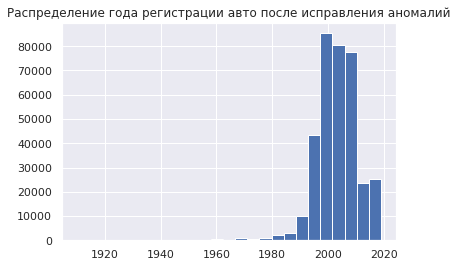

In [26]:
sns.set()
df_autos['reg_year'].hist(bins=25)
plt.title('Распределение года регистрации авто после исправления аномалий')
plt.show()

В заключение избавимся от аномально низких значений в целевом признаке путем удаления строк

In [27]:
df_autos[df_autos['price_euro'] <= 20]['price_euro'].count()

12228

In [28]:
df_autos[(df_autos['price_euro'] <= 20) & (df_autos['price_euro'] >= 10)]['price_euro'].count()

200

In [29]:
df_autos = df_autos[df_autos['price_euro'] > 20]

Исследуем датасет на наличие дубликатов после проделанных преобразований

In [30]:
df_autos.duplicated().sum()

6680

In [31]:
df_autos[df_autos.duplicated()].head()

,date_crawled,price_euro,vehicle_type,reg_year,gearbox,power,model,kilometer,reg_month,fuel_type,brand,not_repaired,date_created,zip_code,last_seen,region,active_period,month_created
8803,2016-03-12,1700,sedan,2004.0,manual,125.0,mondeo,150000,9,gasoline,ford,missing,2016-03-12,53520,2016-03-12,53,0,3
9413,2016-03-21,3399,small,2002.0,manual,90.0,one,150000,8,petrol,mini,no,2016-03-21,45739,2016-03-23,45,2,3
10699,2016-03-22,1800,bus,1997.0,auto,100.0,vito,150000,8,gasoline,mercedes_benz,no,2016-03-22,22885,2016-03-22,22,0,3
10773,2016-03-24,16000,sedan,2014.0,auto,150.0,a3,20000,3,gasoline,audi,no,2016-03-24,10115,2016-03-24,10,0,3
10980,2016-04-01,14999,bus,2007.0,manual,131.0,transporter,150000,10,gasoline,volkswagen,no,2016-04-01,83533,2016-04-05,83,4,4


Видим, что теперь их 6680 вместо начальных 4. Избавимся и от них

In [32]:
df_autos.drop_duplicates(inplace=True)
df_autos.duplicated().sum()

0

                                             |          | [  0%]   00:00 -> (? left)


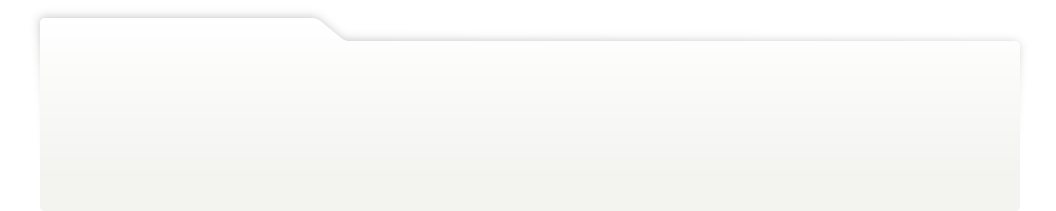
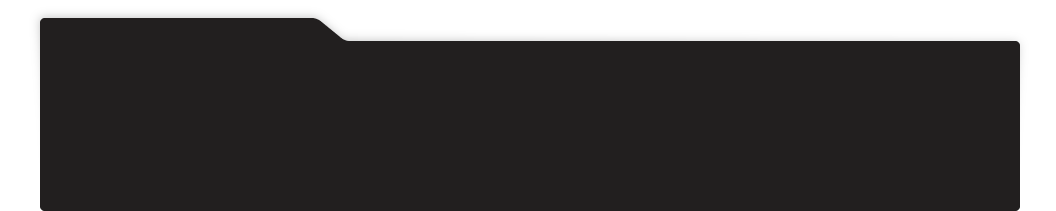
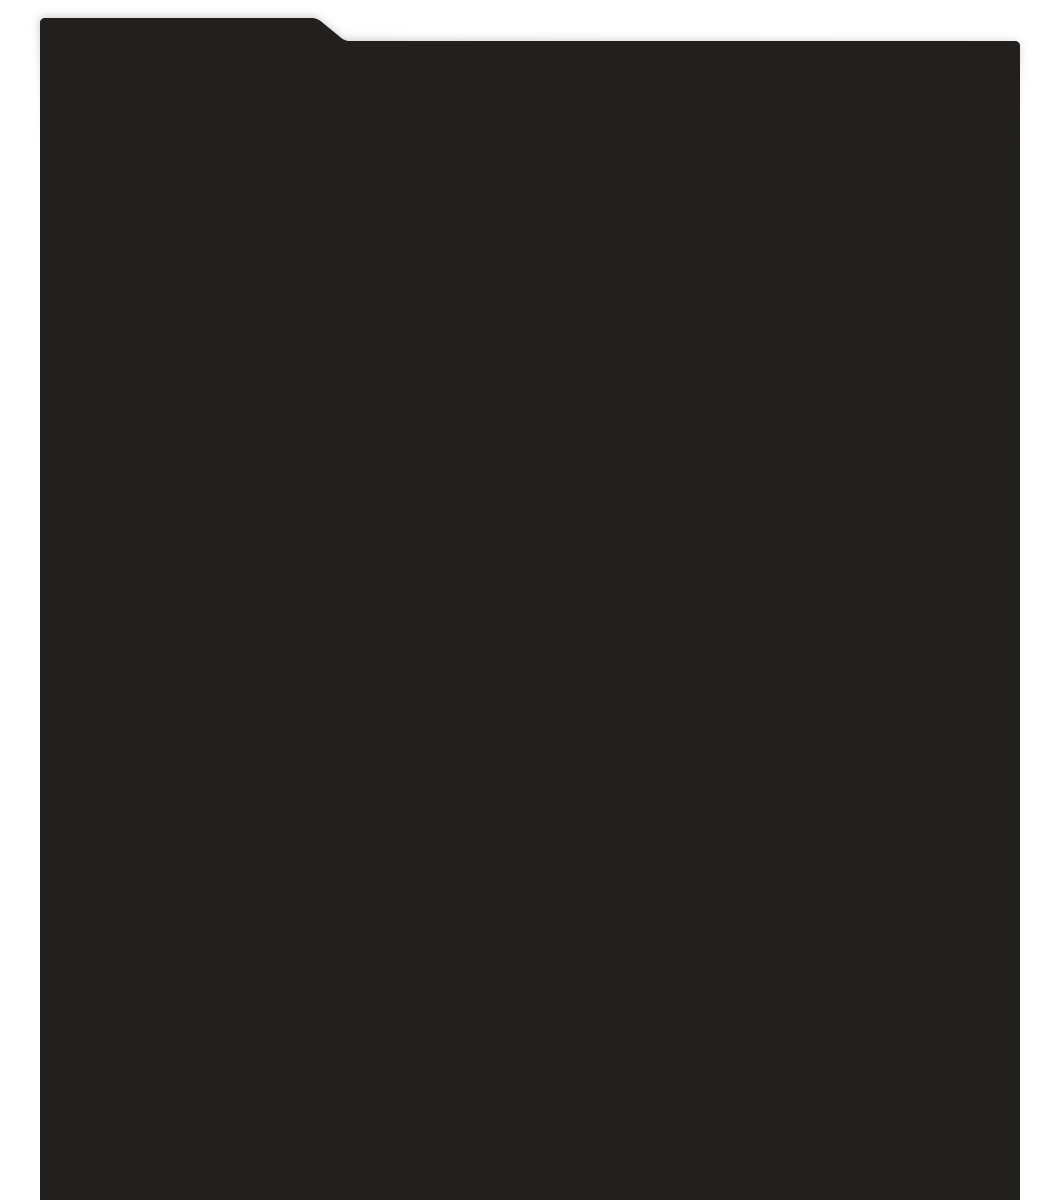
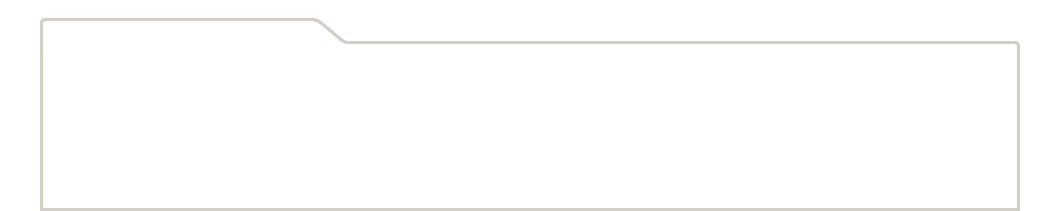
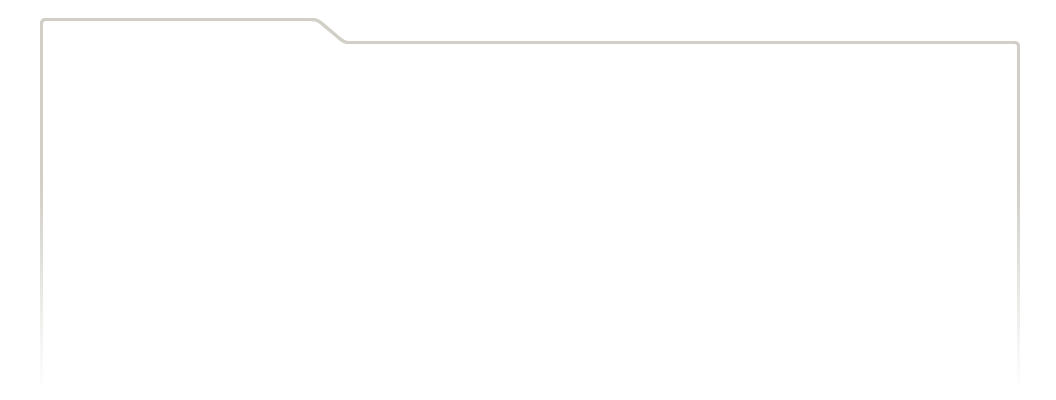
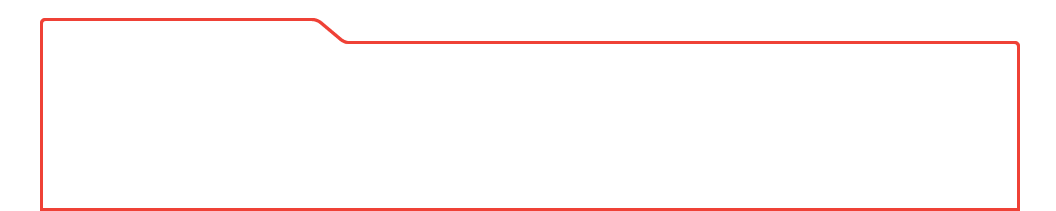
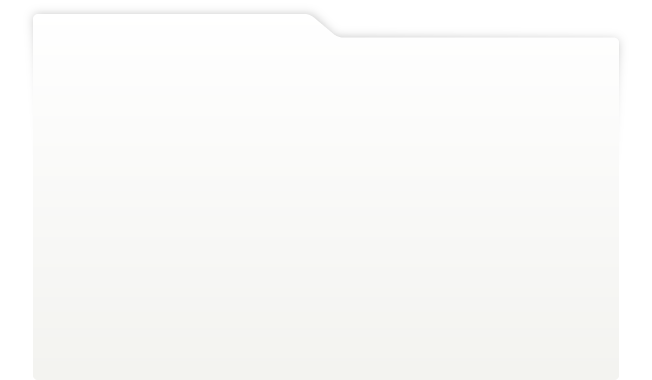
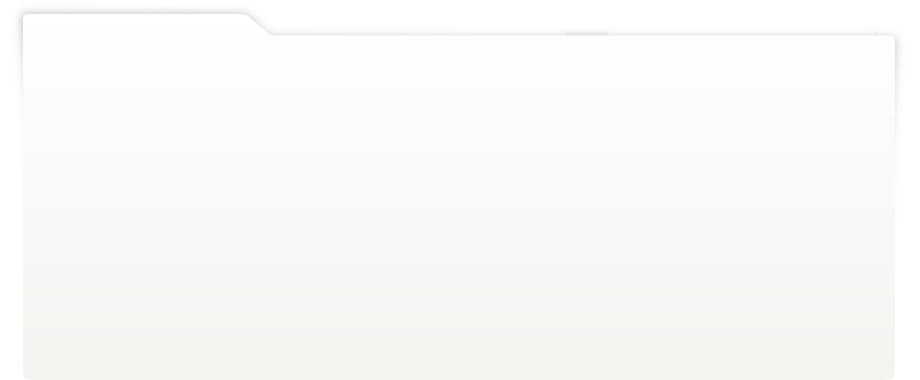
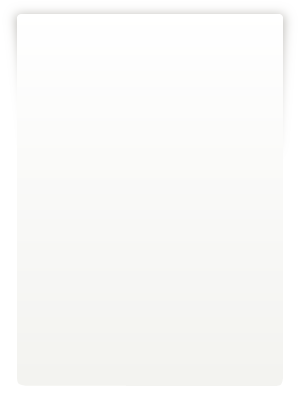
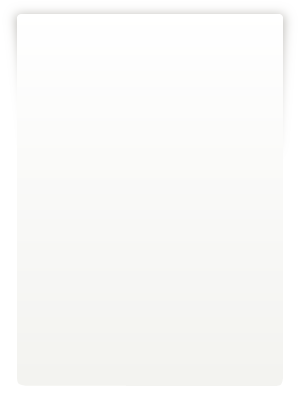
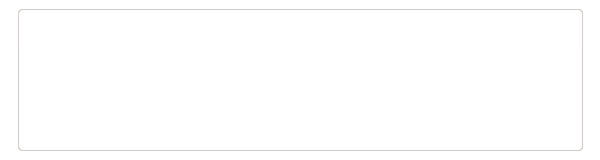
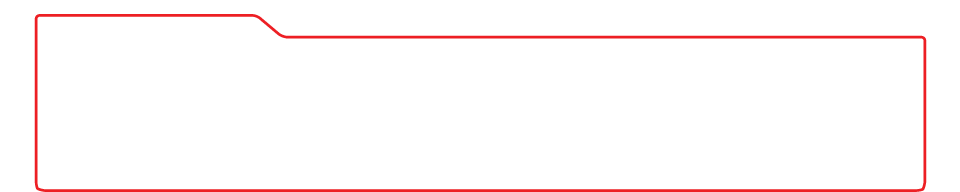
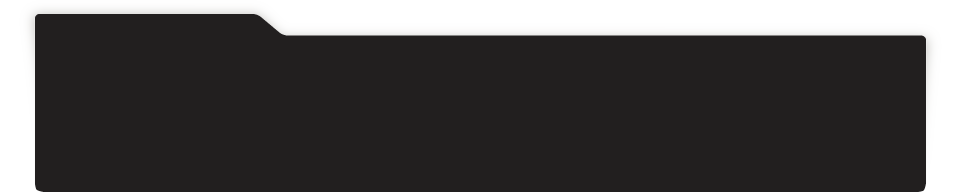
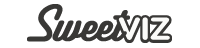
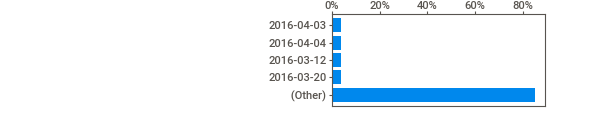
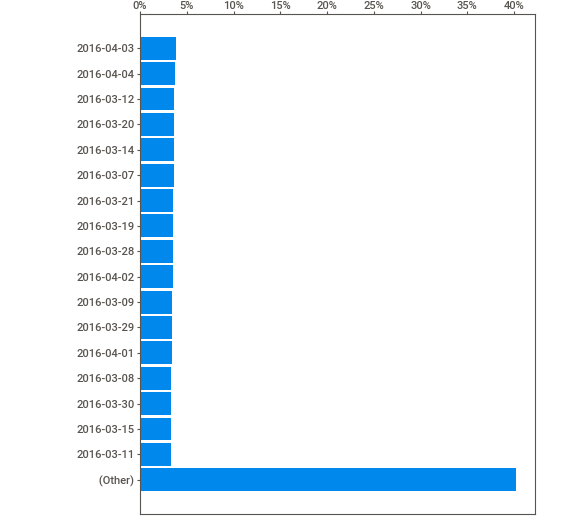
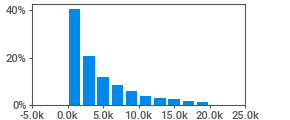
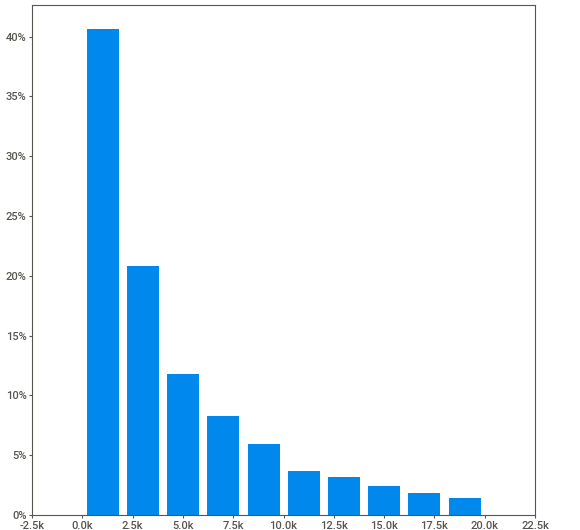
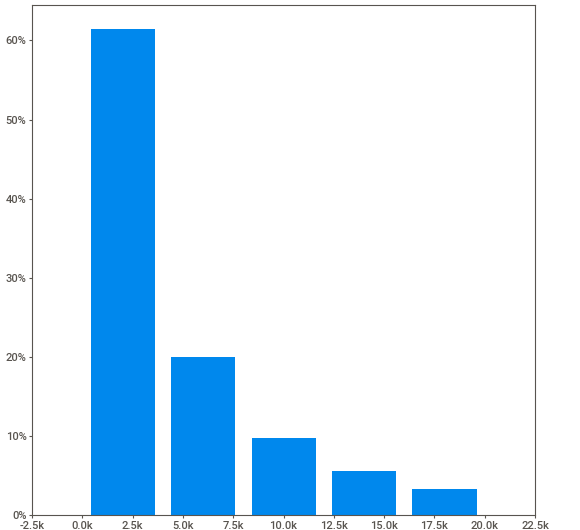
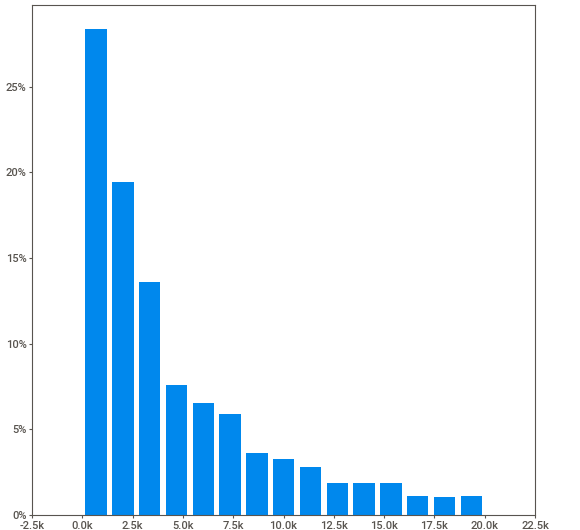
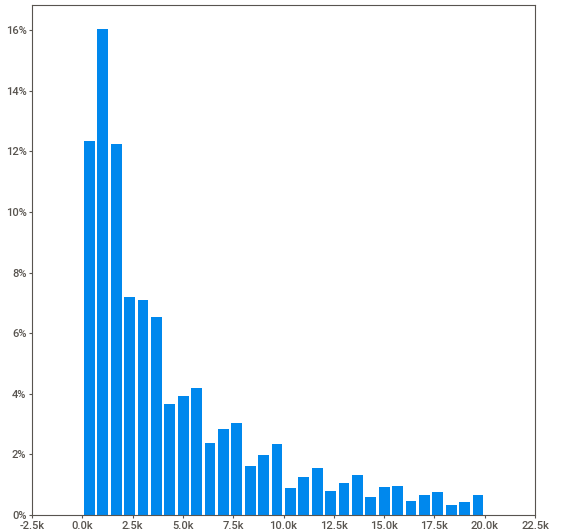
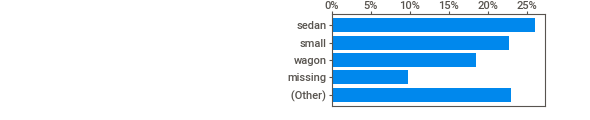
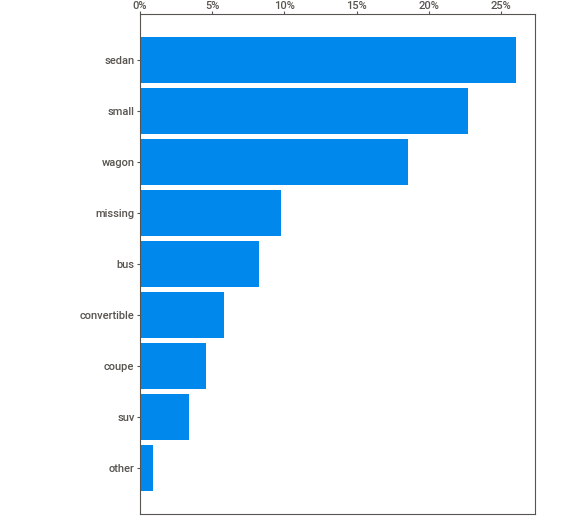
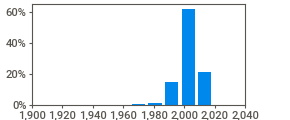
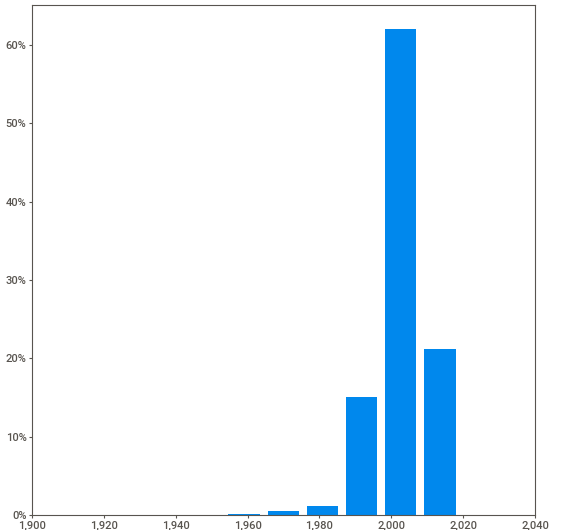
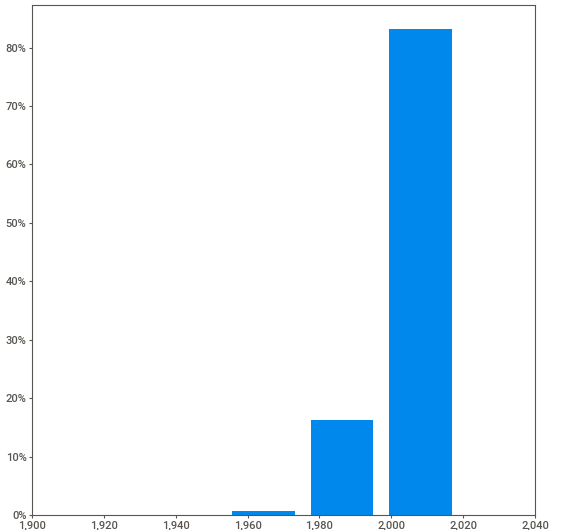
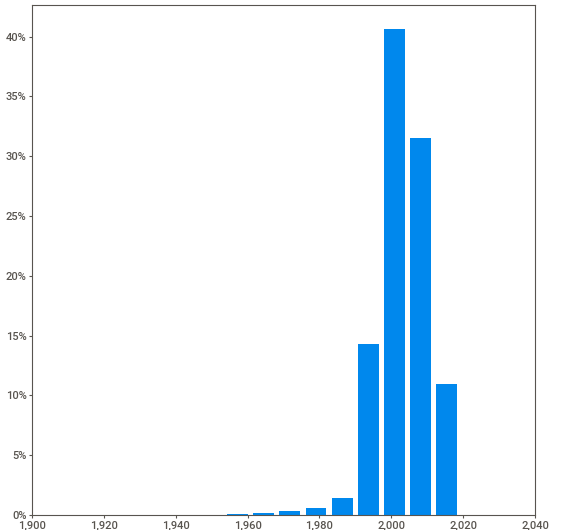
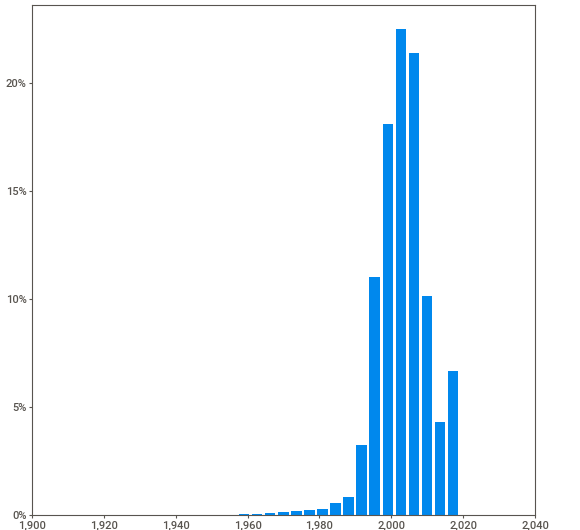
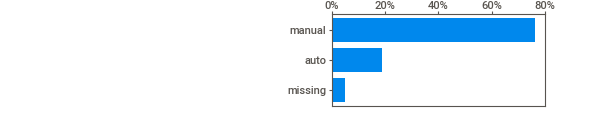
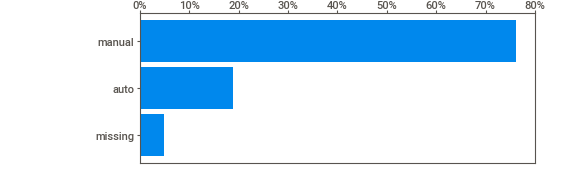
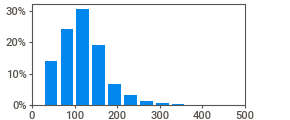
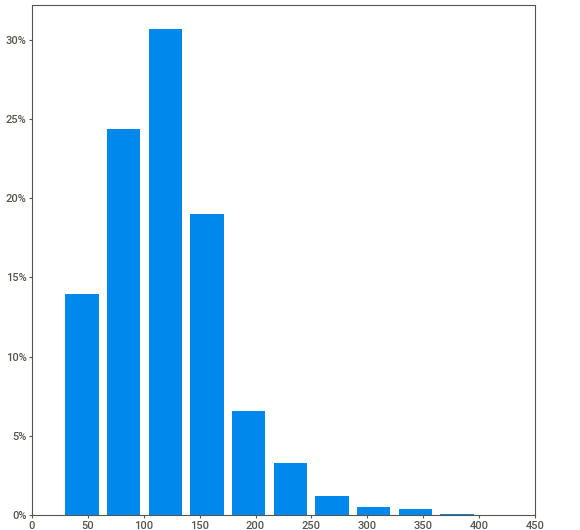
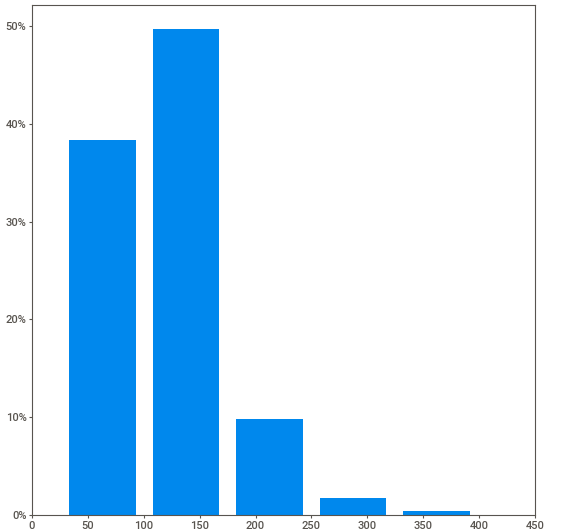
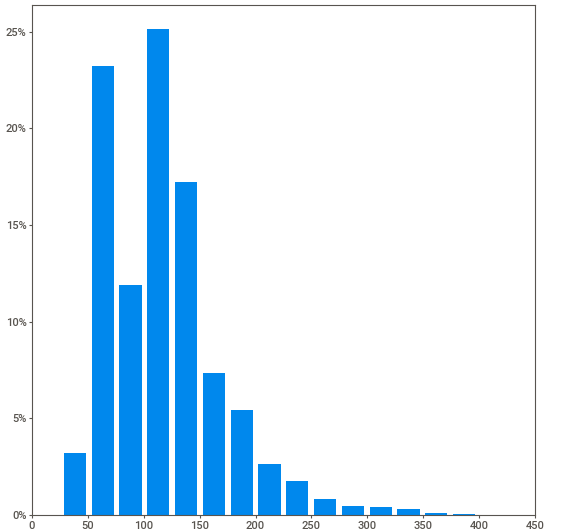
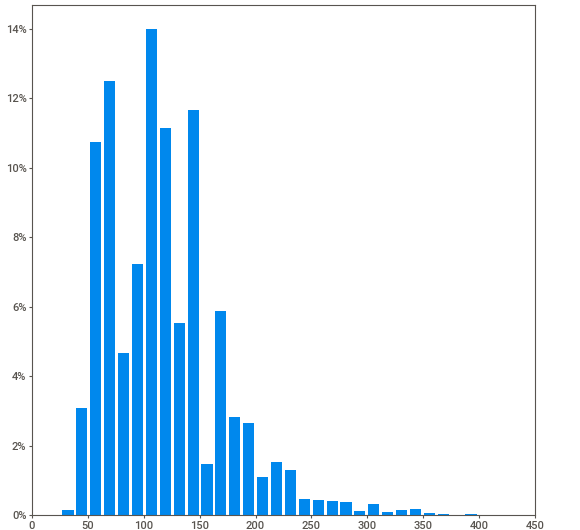
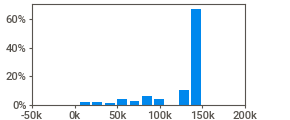
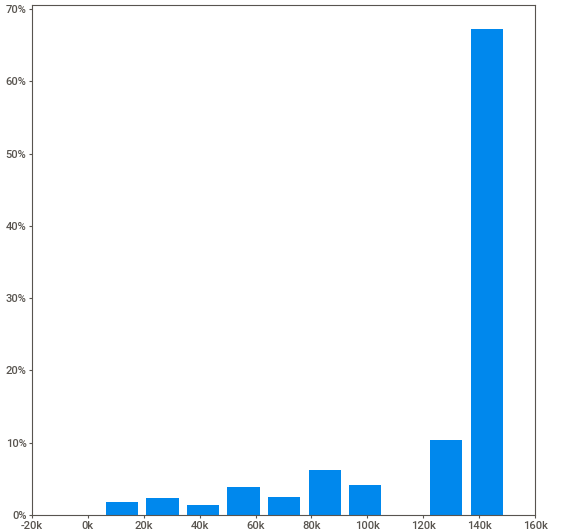
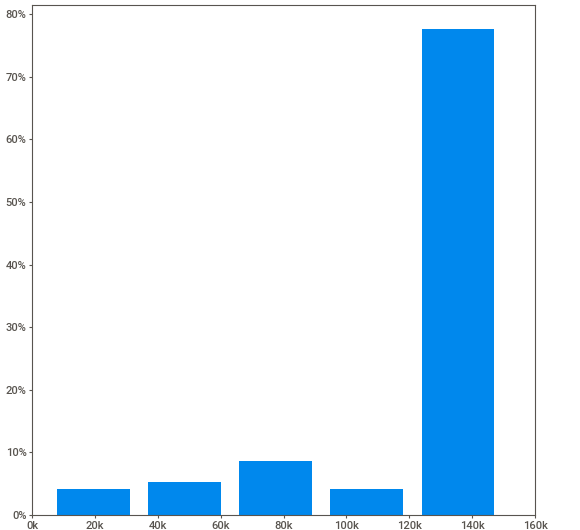
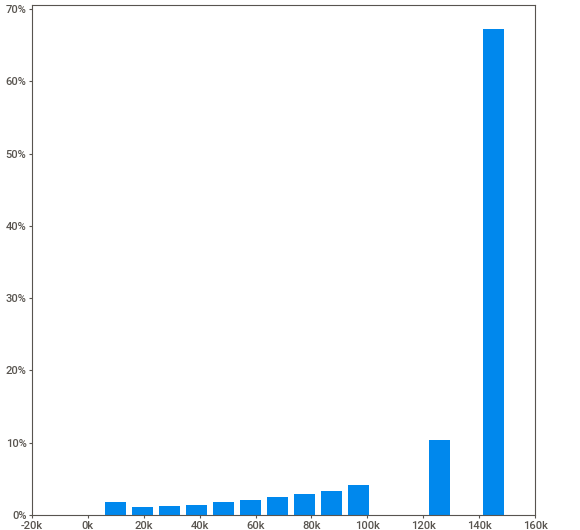
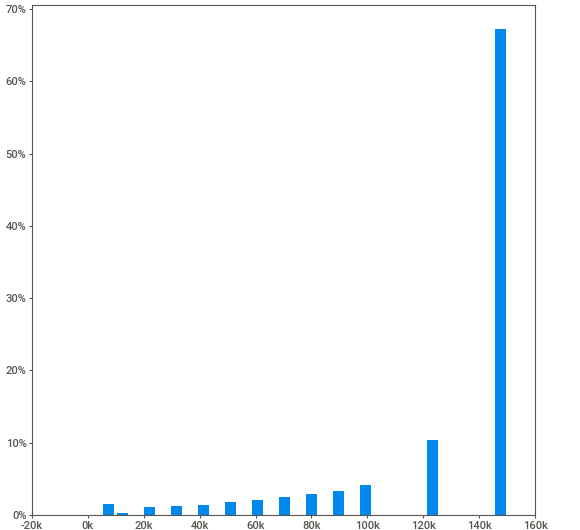
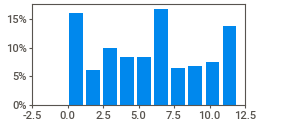
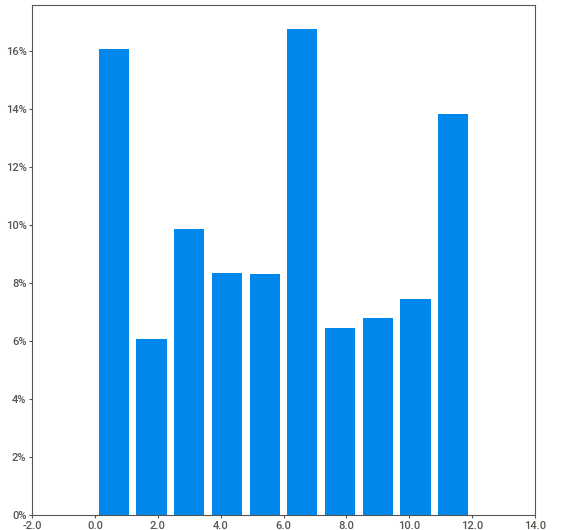
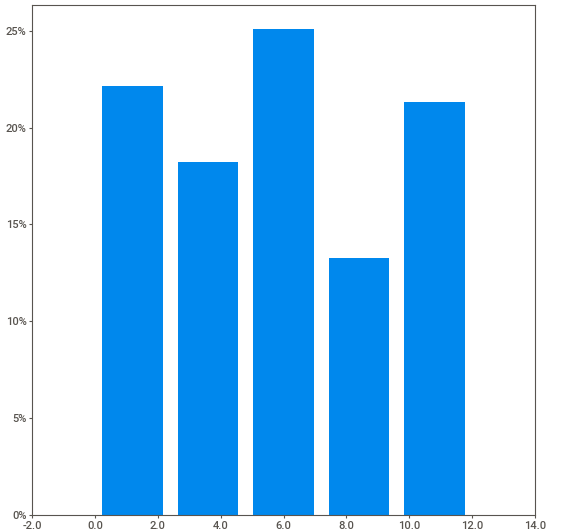
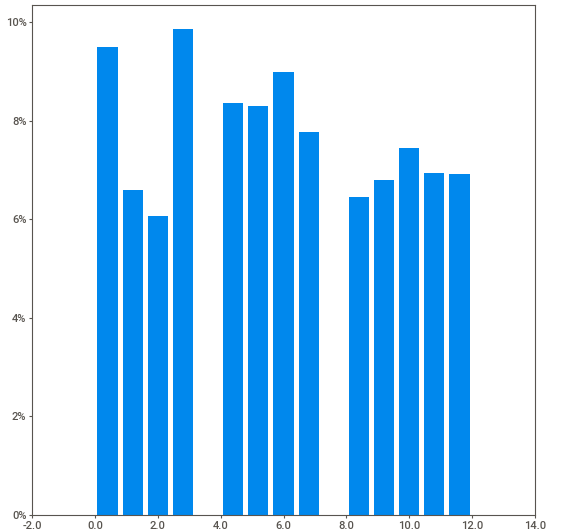
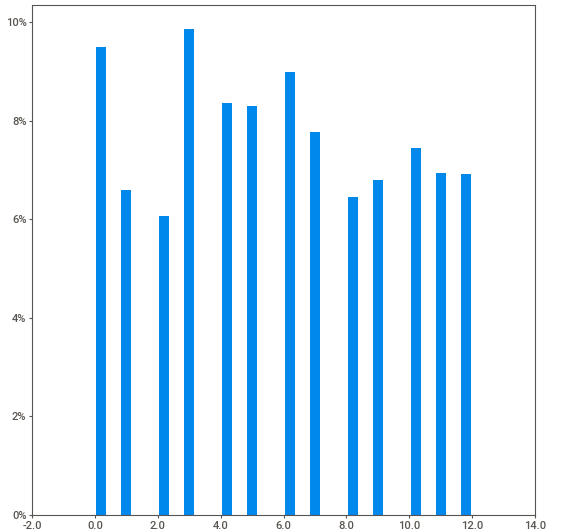
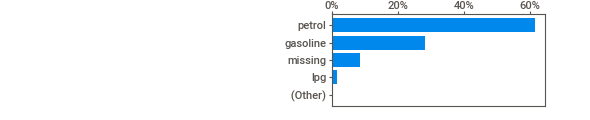
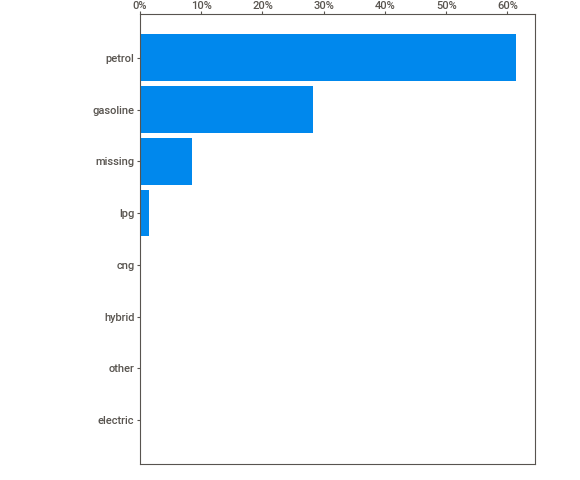
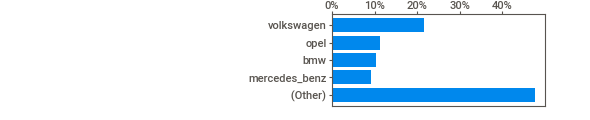
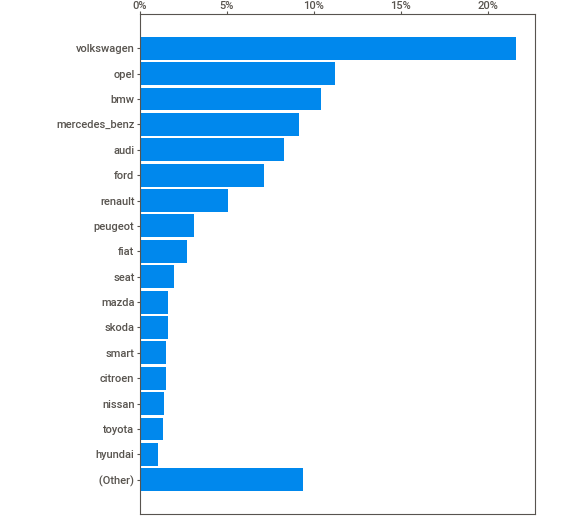
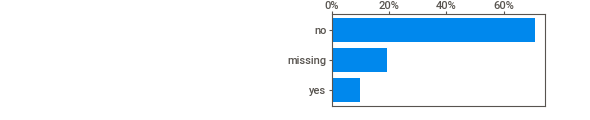
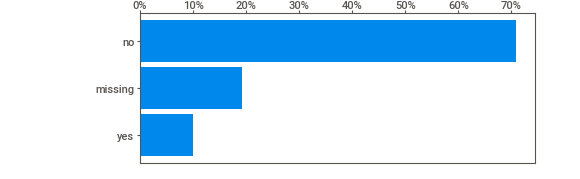
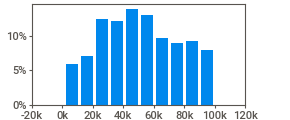
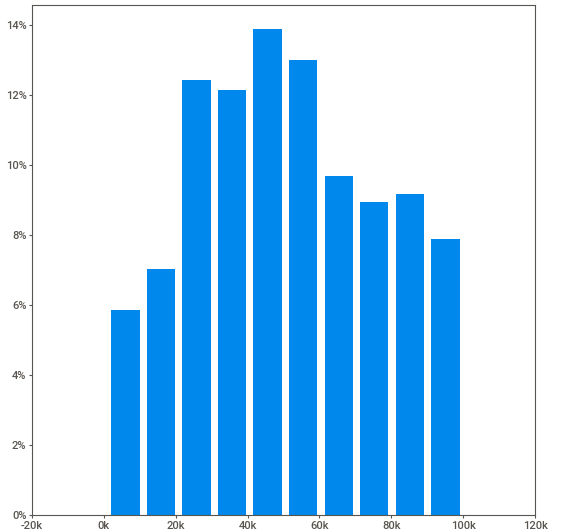
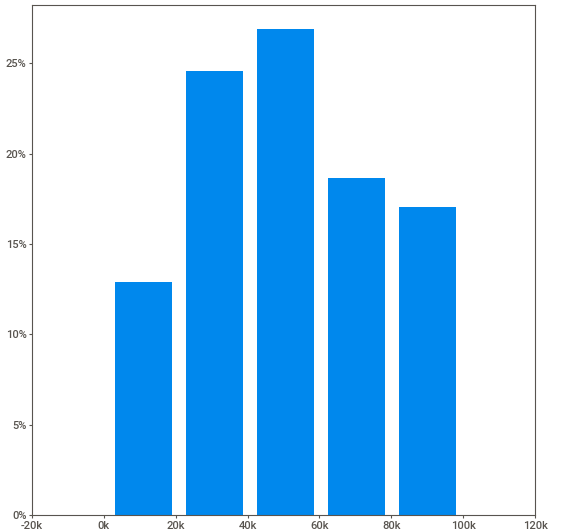
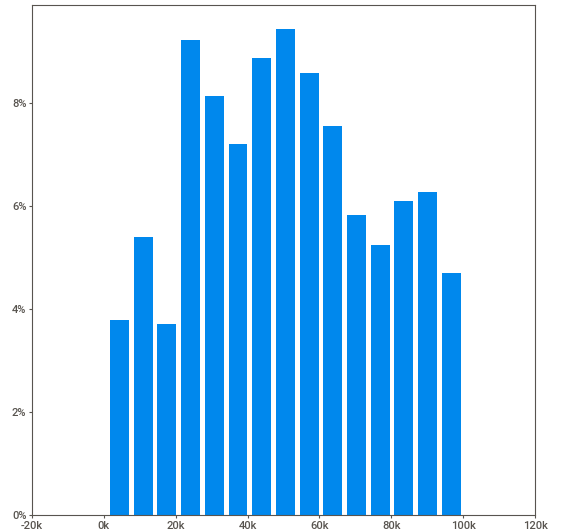
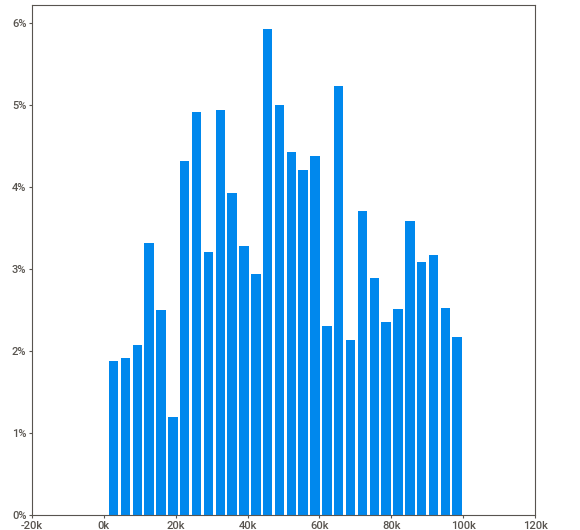
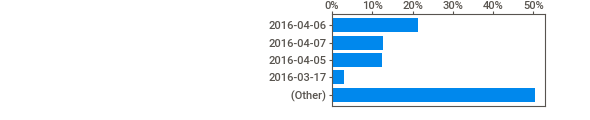
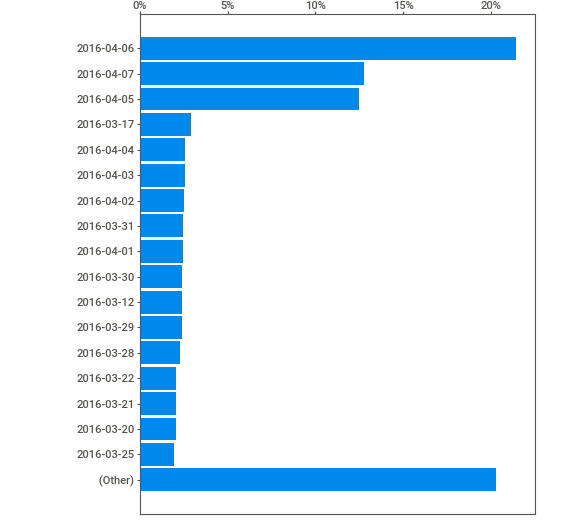
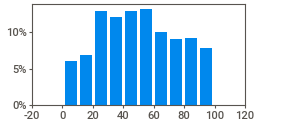
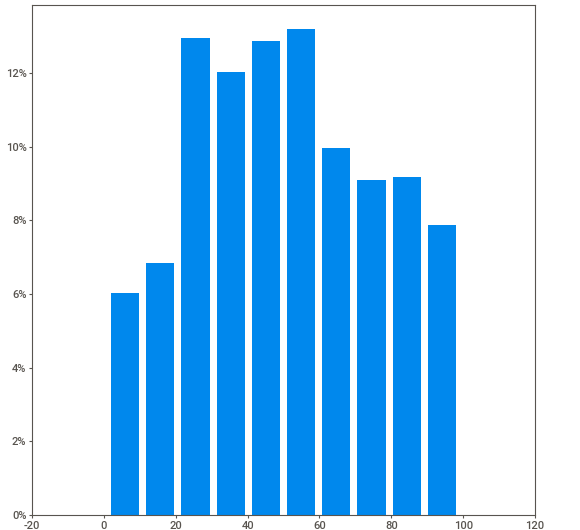
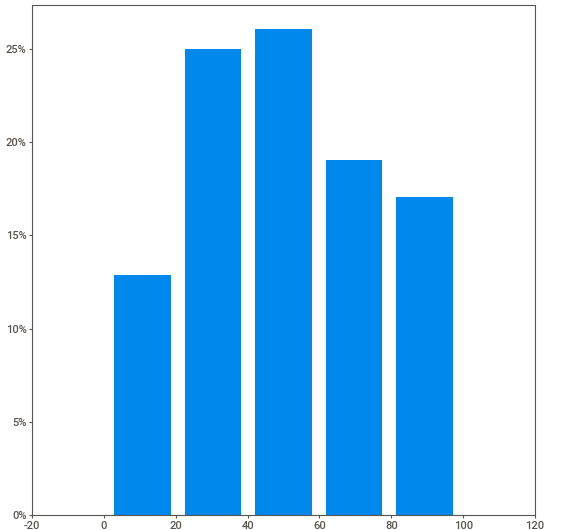
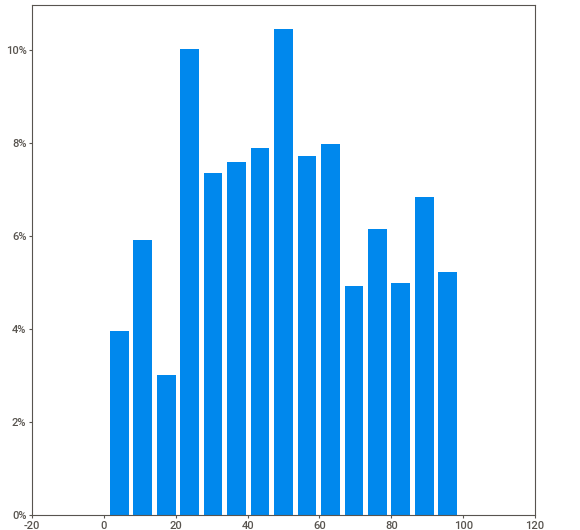
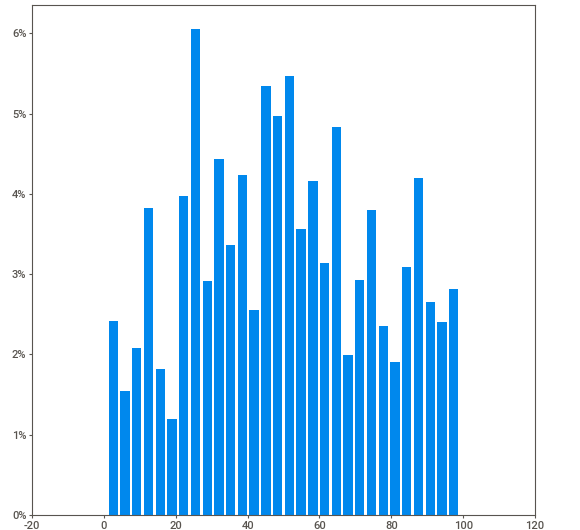
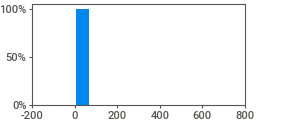
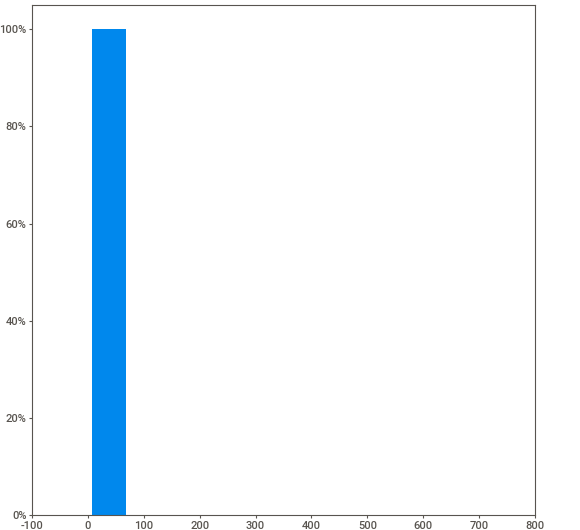
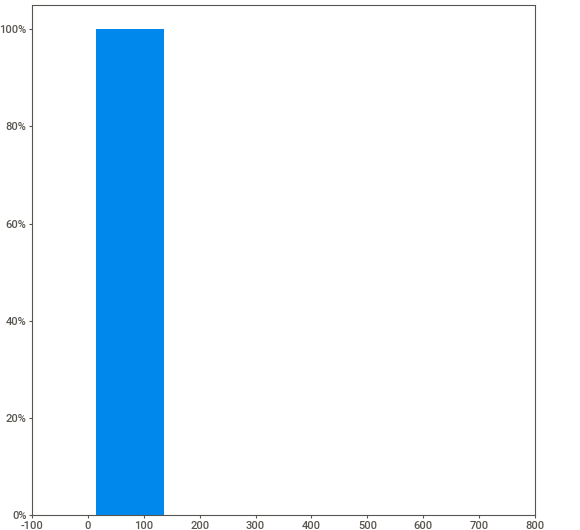
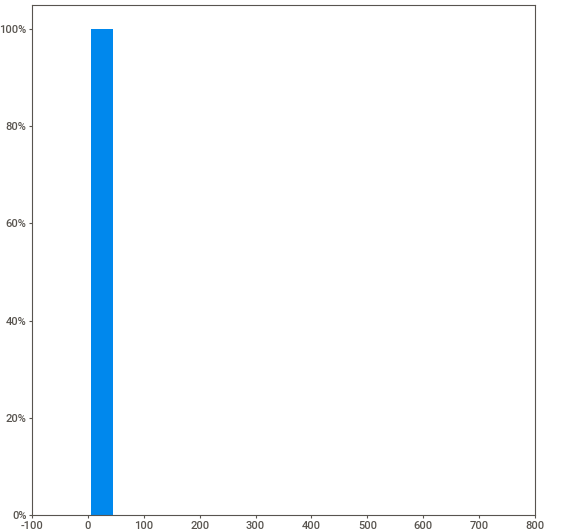
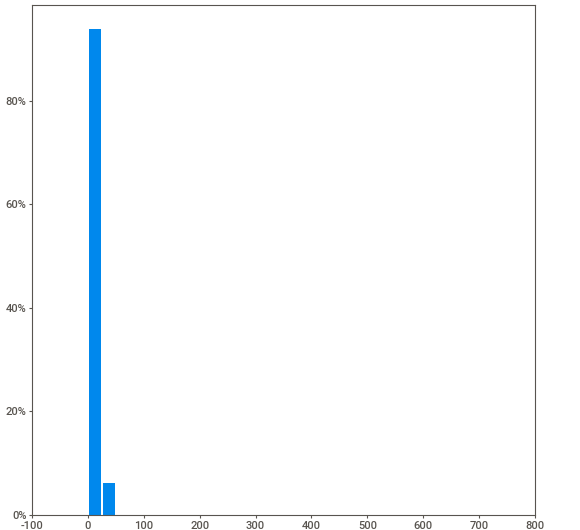
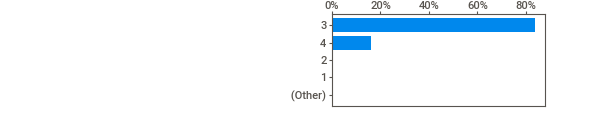
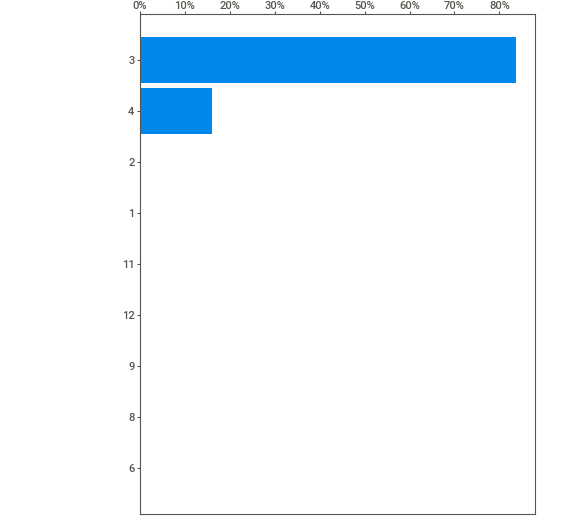
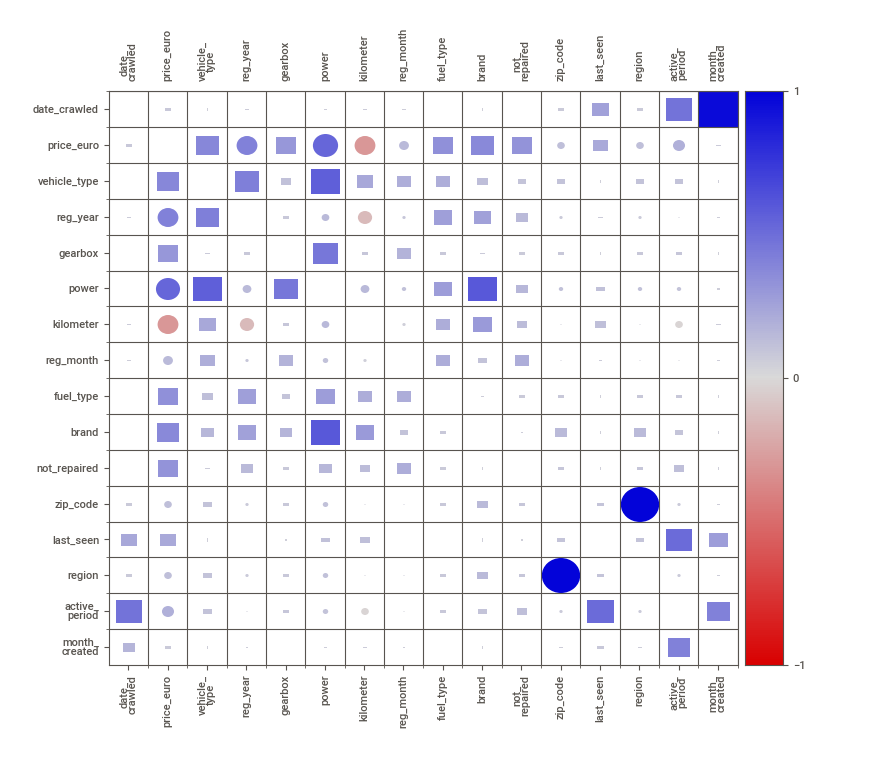
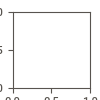

In [32]:
report_df_autos = sv.analyze([df_autos, 'Автомобили и цены'], pairwise_analysis='on')
report_df_autos.show_notebook(w='100%', h='full', scale=None, filepath=None)

Из временных признаков уберем признак date_created, так как он практически совпадает с признаком date_crawled и не несет информации

In [33]:
df_autos.drop(['date_created'], axis=1, inplace=True)

In [34]:
df_autos.drop(['last_seen'], axis=1, inplace=True)

**Выводы**

* После предобработки данных имеем датасет из 335 461 строк с 17 фичами и 1 целевым признаком
* Пропуски, которые были только в категориальных признаках, заменили на значение missing
* Вследствие заполненности признака num_photo одними нулями, удалили этот признак как лишний
* У временных признаков ограничили время датами для лучшей группировки этих признаков
* Избавились от аномально низких значений в целевом признаке, аномалии в годе регистрации и мощности авто исправили на медианные значения по марке и модели
* Внесенены 3 новых признака: регион (вычислен по почтовому индексу), месяц подачи и период активности объявления
* Признаки date_created и last_seen удалили как лишние

## Обучение моделей

Разделим данные на обучающую и тестовую выборки

In [35]:
X = df_autos.drop('price_euro', axis=1).copy()
y = df_autos['price_euro'].copy()

In [36]:
state = RandomState(12345)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(251595, 15) (83866, 15) (251595,) (83866,)


Так как для регрессионных моделей требуются численные данные, переведем категориальные фичи в числа методом кодирования OneHotEncoder (для линейной регрессии) и OrdinalEncoder (для DecisionTree и RandomForest), а числовые - стандартизируем методом StandardScaler. С помощью функции make_column_transformer создадим единый метод подготовки фичей col_transformer

In [38]:
col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='error', drop='first', sparse=False),
        make_column_selector(dtype_include=object),
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include='number'),
    ),

    remainder='passthrough',
)

In [39]:
col_transformer_oe = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='error'),
        make_column_selector(dtype_include=object),
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include='number'),
    ),
    remainder='passthrough',
)

In [40]:
col_transformer_oe_2 = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='error'),
        make_column_selector(dtype_include=object),
    ),
    remainder='passthrough',
)

In [41]:
%%time

X_train_encoded_ohe = pd.DataFrame(col_transformer_ohe.fit_transform(X_train))
X_test_encoded_ohe = pd.DataFrame(col_transformer_ohe.transform(X_test))
X_train_encoded_ohe.head()

CPU times: user 1.33 s, sys: 1.27 s, total: 2.6 s
Wall time: 2.6 s


,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.246150,2.997565,0.576139,0.058335,-0.673983,-0.671021,-0.775281,-0.423672
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.976881,0.079610,-0.762845,-0.482197,1.227866,1.229969,2.204829,-0.423672
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.061503,-0.970854,-1.566235,0.328601,1.774950,1.773109,-0.546042,-0.423672
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.197396,0.488123,-1.834031,-0.211931,1.653928,1.656721,-0.087563,-0.423672
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.197396,-0.251092,-2.101828,-0.211931,0.789888,0.803216,1.975590,-0.423672


In [42]:
X_test_encoded_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.297419,-0.406716,0.576139,1.679930,0.210667,0.221280,0.944013,-0.423672
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.197396,0.877184,-0.762845,0.058335,-0.913349,-0.903795,0.600154,-0.423672
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.976881,1.772024,0.576139,0.328601,0.950812,0.958399,0.944013,-0.423672
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.061503,-0.795777,-1.834031,0.598867,1.254958,1.268764,-0.431422,-0.423672
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.297419,-0.834683,0.576139,-0.752463,-0.631559,-0.632225,0.027056,-0.423672


In [43]:
%%time

X_train_encoded_oe = pd.DataFrame(col_transformer_oe.fit_transform(X_train))
X_test_encoded_oe = pd.DataFrame(col_transformer_oe.transform(X_test))
X_train_encoded_oe.head()

CPU times: user 894 ms, sys: 25.6 ms, total: 919 ms
Wall time: 935 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,13.0,5.0,0.0,15.0,2.0,2.0,2.0,0.246150,2.997565,0.576139,0.058335,-0.673983,-0.671021,-0.775281,-0.423672
1,4.0,5.0,1.0,59.0,7.0,20.0,1.0,-0.976881,0.079610,-0.762845,-0.482197,1.227866,1.229969,2.204829,-0.423672
2,25.0,6.0,1.0,211.0,7.0,3.0,1.0,1.061503,-0.970854,-1.566235,0.328601,1.774950,1.773109,-0.546042,-0.423672
3,24.0,8.0,1.0,29.0,2.0,1.0,1.0,1.197396,0.488123,-1.834031,-0.211931,1.653928,1.656721,-0.087563,-0.423672
4,6.0,5.0,2.0,124.0,2.0,38.0,1.0,1.197396,-0.251092,-2.101828,-0.211931,0.789888,0.803216,1.975590,-0.423672


In [44]:
X_test_encoded_oe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,11.0,5.0,1.0,82.0,7.0,36.0,1.0,-0.297419,-0.406716,0.576139,1.679930,0.210667,0.221280,0.944013,-0.423672
1,6.0,0.0,1.0,112.0,2.0,10.0,1.0,1.197396,0.877184,-0.762845,0.058335,-0.913349,-0.903795,0.600154,-0.423672
2,15.0,7.0,0.0,167.0,2.0,10.0,1.0,-0.976881,1.772024,0.576139,0.328601,0.950812,0.958399,0.944013,-0.423672
3,25.0,6.0,1.0,119.0,7.0,12.0,1.0,1.061503,-0.795777,-1.834031,0.598867,1.254958,1.268764,-0.431422,-0.423672
4,7.0,5.0,1.0,116.0,7.0,38.0,1.0,-0.297419,-0.834683,0.576139,-0.752463,-0.631559,-0.632225,0.027056,-0.423672


In [45]:
oe_columns = ['date_crawled', 'vehicle_type', 'gearbox', 'model', 'fuel_type', 
              'brand', 'not_repaired', 'reg_year', 'power', 'kilometer', 'reg_month', 
              'zip_code', 'region', 'active_period', 'month_created']

In [46]:
%%time

X_train_encoded_oe_2 = pd.DataFrame(col_transformer_oe_2.fit_transform(X_train), columns=oe_columns)
X_test_encoded_oe_2 = pd.DataFrame(col_transformer_oe_2.transform(X_test), columns=oe_columns)
X_train_encoded_oe_2.head()

CPU times: user 831 ms, sys: 23.1 ms, total: 854 ms
Wall time: 861 ms


,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,reg_year,power,kilometer,reg_month,zip_code,region,active_period,month_created
0,13.0,5.0,0.0,15.0,2.0,2.0,2.0,2005.0,272.0,150000.0,6.0,33378.0,33.0,2.0,3.0
1,4.0,5.0,1.0,59.0,7.0,20.0,1.0,1996.0,122.0,100000.0,4.0,82377.0,82.0,28.0,3.0
2,25.0,6.0,1.0,211.0,7.0,3.0,1.0,2011.0,68.0,70000.0,7.0,96472.0,96.0,4.0,3.0
3,24.0,8.0,1.0,29.0,2.0,1.0,1.0,2012.0,143.0,60000.0,5.0,93354.0,93.0,8.0,3.0
4,6.0,5.0,2.0,124.0,2.0,38.0,1.0,2012.0,105.0,50000.0,5.0,71093.0,71.0,26.0,3.0


In [47]:
X_test_encoded_oe_2.head()

,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,reg_year,power,kilometer,reg_month,zip_code,region,active_period,month_created
0,11.0,5.0,1.0,82.0,7.0,36.0,1.0,2001.0,97.0,150000.0,12.0,56170.0,56.0,17.0,3.0
1,6.0,0.0,1.0,112.0,2.0,10.0,1.0,2012.0,163.0,100000.0,6.0,27211.0,27.0,14.0,3.0
2,15.0,7.0,0.0,167.0,2.0,10.0,1.0,1996.0,209.0,150000.0,7.0,75239.0,75.0,17.0,3.0
3,25.0,6.0,1.0,119.0,7.0,12.0,1.0,2011.0,77.0,60000.0,8.0,83075.0,83.0,5.0,3.0
4,7.0,5.0,1.0,116.0,7.0,38.0,1.0,2001.0,75.0,150000.0,3.0,34471.0,34.0,9.0,3.0


In [48]:
# del X_train
# del X_test

Оценим время обучения различных моделей регрессии и их метрику качества RSME

In [45]:
%%script false
%%time

cv = 5
rmse = 'neg_root_mean_squared_error' 
models = [DecisionTreeRegressor(random_state=state), 
          RandomForestRegressor(random_state=state)]


results_cross_val_0 = []

for model in models: 
    start_time = time.time()
    cv_score = cross_val_score(model, 
                               X_train_encoded_oe, 
                               y_train, 
                               cv=cv, 
                               scoring=rmse,
                               n_jobs=-1).mean()    
    
    elapsed_time = time.time() - start_time
    results_cross_val_0.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': int(cv_score),
                              'learn_time': int(elapsed_time)}) 

CPU times: user 15min 10s, sys: 6.88 s, total: 15min 17s
Wall time: 15min 22s


In [46]:
%%script false
%%time

models = [LinearRegression()]

for model in models: 
    start_time = time.time()
    cv_score = cross_val_score(model, 
                               X_train_encoded_ohe, 
                               y_train, 
                               cv=cv, 
                               scoring=rmse,
                               n_jobs=-1).mean()    
    
    elapsed_time = time.time() - start_time
    results_cross_val_0.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': int(cv_score),
                              'learn_time': int(elapsed_time)}) 

CPU times: user 2min 19s, sys: 1min 11s, total: 3min 30s
Wall time: 3min 30s


In [47]:
%%script false
%%time

models = [LGBMRegressor(),
          CatBoostRegressor(verbose=False)]

for model in models: 
    start_time = time.time()
    cv_score = cross_val_score(model, 
                               X_train_encoded_ohe, 
                               y_train, 
                               cv=cv, 
                               scoring=rmse,
                               n_jobs=-1).mean()    
    
    elapsed_time = time.time() - start_time
    results_cross_val_0.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': int(cv_score),
                              'learn_time': int(elapsed_time)}) 

CPU times: user 9min 56s, sys: 7.37 s, total: 10min 3s
Wall time: 10min 15s


In [48]:
%%script false
pd.DataFrame(results_cross_val_0).sort_values('cross_val_score', ascending=False)

,model_name,cross_val_score,learn_time
4,CatBoostRegressor,-1614,315
1,RandomForestRegressor,-1649,908
3,LGBMRegressor,-1705,299
0,DecisionTreeRegressor,-2309,14
2,LinearRegression,-2628,210


**Выводы**

Лучший результат на наших данных показали модели RandomForest и CatBoost, но время обучения первой модели 10 мин, а второй - меньше 3-х, чуть хуже результат модели LightGBM, зато она оказалась самой быстрой (30 сек)

## Анализ моделей

#### Анализ модели RandomForest

In [49]:
%%script false
%%time

pipe = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'model': [RandomForestRegressor(random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10),
        'model__n_estimators': np.arange(10, 81, 20),
    }
]
rmse = 'neg_root_mean_squared_error'
cv = KFold(n_splits=5, shuffle=False)

search = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=rmse)
search.fit(X_train_encoded_oe, y_train)

print('Best Params:', search.best_params_)
print('Best Score:', search.best_score_)

Best Params: {'model': RandomForestRegressor(max_features=0.4, n_estimators=70,
                      random_state=RandomState(MT19937) at 0x7F62AF946B40), 'model__max_features': 0.4, 'model__n_estimators': 70}
Best Score: -1611.5366992567874
CPU times: user 2h 20min 24s, sys: 1min 4s, total: 2h 21min 28s
Wall time: 2h 22min 30s


Wall time: 3min 8s


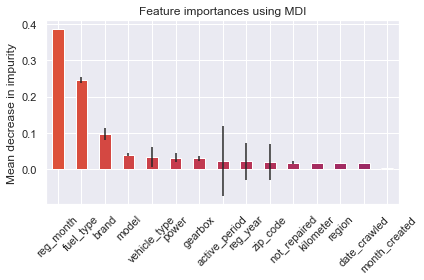

In [45]:
%%time

model = RandomForestRegressor(random_state=state, max_features=0.4, n_estimators=70).fit(X_train_encoded_oe_2, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
model_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
color = cm.inferno_r(np.linspace(.4,.8, 30))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax, stacked=True,  color=color, rot=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Оценка главных компонент показывает, что на целевой признак цены автомобиля основное влияние оказывают только три признака: марка, битая/небитая и возраст 

#### Анализ модели градиентного бустинга LightGBM (Light Gradient Boosted Machine)

Оценка качества модели с дефолтными настройками

In [46]:
%%time

rmse = 'neg_root_mean_squared_error'
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_encoded_oe_2, y_train, scoring=rmse, cv=cv, n_jobs=-1, error_score='raise')
print('RMSE: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

RMSE: -1724.119 (15.378)
CPU times: user 1h 4min 37s, sys: 19.8 s, total: 1h 4min 57s
Wall time: 1h 5min 14s


Хотя LGBM может определить категории автоматически, лучше передать список категориальных столбцов в явном виде 

In [47]:
X_train.columns

Index(['date_crawled', 'vehicle_type', 'reg_year', 'gearbox', 'power', 'model',
       'kilometer', 'reg_month', 'fuel_type', 'brand', 'not_repaired',
       'zip_code', 'region', 'active_period', 'month_created'],
      dtype='object')

In [48]:
%%time

cat_features = ['date_crawled', 'vehicle_type', 'reg_year', 
                'gearbox', 'model', 'reg_month', 'fuel_type', 
                'brand', 'zip_code', 'region', 'not_repaired', 'month_created']

params = {
    'objective': 'regression', 
    'metric': 'rmse'
}

train_data = lgb.Dataset(X_train_encoded_oe_2, y_train, 
                         feature_name=X_train.columns.tolist(), 
                         categorical_feature=cat_features, 
                         free_raw_data=False)

valid_data = lgb.Dataset(X_test_encoded_oe_2, y_test, 
                         feature_name=X_train.columns.tolist(),
                         categorical_feature=cat_features, 
                         free_raw_data=False)

booster = lgb.train(params, 
                    train_set=train_data, 
                    valid_sets=valid_data, 
                    verbose_eval=20, 
                    categorical_feature=cat_features, 
                    num_boost_round=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7911
[LightGBM] [Info] Number of data points in the train set: 251595, number of used features: 15
[LightGBM] [Info] Start training from score 4561.194992


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[20]	valid_0's rmse: 2006.87
[40]	valid_0's rmse: 1750.48
[60]	valid_0's rmse: 1700.8
[80]	valid_0's rmse: 1680.17
[100]	valid_0's rmse: 1666.76


In [49]:
cat_features = ['date_crawled', 'vehicle_type', 'reg_year', 
                'gearbox', 'model', 'reg_month', 'fuel_type', 
                'brand', 'zip_code', 'region', 'not_repaired', 'month_created']

In [50]:
%%time

booster = lgb.LGBMModel(objective='regression', n_estimators=100, verbose=1)

booster.fit(X_train_encoded_oe_2, y_train, 
            eval_set=[(X_test_encoded_oe_2, y_test),], 
            eval_metric='rmse', 
            categorical_feature=cat_features,)

test_preds = booster.predict(X_test_encoded_oe_2)
train_preds = booster.predict(X_train_encoded_oe_2)

print('\nTest  RMSE: %.2f' % mean_squared_error(y_test, test_preds, squared=False))
print('Train RMSE: %.2f' % mean_squared_error(y_train, train_preds, squared=False))

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'date_crawled', 'fuel_type', 'gearbox', 'model', 'month_created', 'not_repaired', 'reg_month', 'reg_year', 'region', 'vehicle_type', 'zip_code']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7865
[LightGBM] [Info] Number of data points in the train set: 251595, number of used features: 15


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4561.194992
[1]	valid_0's rmse: 4187.91	valid_0's l2: 1.75386e+07
[2]	valid_0's rmse: 3900.41	valid_0's l2: 1.52132e+07
[3]	valid_0's rmse: 3647.22	valid_0's l2: 1.33022e+07
[4]	valid_0's rmse: 3425.22	valid_0's l2: 1.17321e+07
[5]	valid_0's rmse: 3225.48	valid_0's l2: 1.04037e+07
[6]	valid_0's rmse: 3052.72	valid_0's l2: 9.31908e+06
[7]	valid_0's rmse: 2902.2	valid_0's l2: 8.42277e+06
[8]	valid_0's rmse: 2767	valid_0's l2: 7.65629e+06
[9]	valid_0's rmse: 2650.37	valid_0's l2: 7.02448e+06
[10]	valid_0's rmse: 2545.87	valid_0's l2: 6.48148e+06
[11]	valid_0's rmse: 2454.42	valid_0's l2: 6.02419e+06
[12]	valid_0's rmse: 2373.6	valid_0's l2: 5.63397e+06
[13]	valid_0's rmse: 2302.88	valid_0's l2: 5.30324e+06
[14]	valid_0's rmse: 2238.43	valid_0's l2: 5.01057e+06
[15]	valid_0's rmse: 2181.18	valid_0's l2: 4.75755e+06
[16]	valid_0's rmse: 2132.27	valid_0's l2: 4.54657e+06
[17]	valid_0's rmse: 2086.91	valid_0's l2: 4.3552e+06
[18]	valid_0's rmse: 204

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

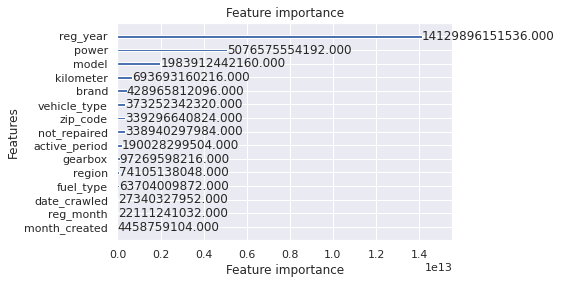

In [51]:
lgb.plot_importance(booster, importance_type='gain')

У LightGBM есть множество гиперпараметров. Поскольку модель градиентного бустинга может обучаться долго, изменим у неё только несколько параметров. Ограничимся количеством деревьев и их глубиной, скоростью обучения и типом бустинга.

#### Исследование гиперпараметров LightGBM

##### Количество деревьев

Важным гиперпараметром для алгоритма LightGBM является количество деревьев решений, используемых в ансамбле. Напомним, что деревья принятия решений добавляются в модель последовательно в попытке исправить и улучшить прогнозы, сделанные предыдущими деревьями. Часто работает правило: больше деревьев — лучше. Количество деревьев можно задать с помощью аргумента n_estimators, по умолчанию равного 100. Исследуем влияние количества деревьев при значениях от 10 до 1000.

>10 -2656.666 (16.207) 10.0
>50 -1821.608 (14.278) 27.8
>100 -1726.543 (12.258) 72.2
>1000 -1579.792 (8.933) 360.0


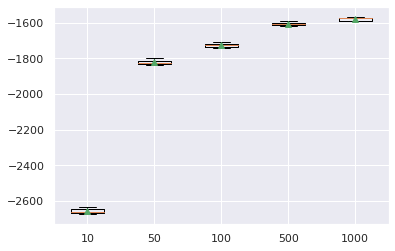

CPU times: user 12min 13s, sys: 3.57 s, total: 12min 16s
Wall time: 12min 22s


In [50]:
%%time

rmse = 'neg_root_mean_squared_error'
def get_models():  # Функция создания списка экземпляров модели с итерированием гиперпараметра
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models[str(n)] = LGBMRegressor(n_estimators=n)
    return models

def evaluate_model(model):  # Расчет метрики модели
    cv = KFold(n_splits=5, shuffle=False)
    scores = cross_val_score(model, X_train_encoded_oe_2, y_train, scoring=rmse, cv=cv, n_jobs=-1)
    return scores

def results_model():  # Расчет моделей и сохранение результатов  
    models = get_models()  # Запись списка моделей в переменную
    results, names = list(), list()  
    for name, model in models.items():    
        start_time = time.time()
        scores = evaluate_model(model)
        results.append(scores)
        names.append(name)
        elapsed_time = time.time() - start_time
        print('>%s %.3f (%.3f) %.1f' % (name, scores.mean(), scores.std(), elapsed_time))
    return results, names

results, names = results_model()  
plt.boxplot(results, labels=names, showmeans=True) # Распределения метрик моделей
plt.show()

##### Глубина дерева

Градиентный бустинг обычно хорошо работает с деревьями, имеющими умеренную глубину, находящую баланс между обученностью и обобщенностью. Глубина дерева контролируется аргументом max_depth, и по умолчанию используется неопредёленное значение, поскольку механизм по умолчанию для управления сложностью деревьев заключается в использовании конечного количества узлов.

Существует два основных способа управления сложностью дерева: через максимальную глубину дерева и максимальное количество терминальных узлов (листьев) дерева. Здесь мы изучаем количество листьев, поэтому нам нужно увеличить их количество, чтобы поддерживать более глубокие деревья, задав аргумент num_leaves. Исследуем глубину дерева от 1 до 10 и их влияние на производительность модели.

>1 -2555.574 (14.643) 38.3
>2 -2128.624 (12.876) 52.1
>3 -1955.368 (11.405) 55.9
>4 -1849.038 (13.626) 66.1
>5 -1775.856 (12.213) 38.2
>6 -1721.879 (10.238) 55.9
>7 -1682.380 (9.740) 62.6
>8 -1645.271 (10.255) 81.2
>9 -1620.982 (8.313) 102.1
>10 -1604.541 (9.066) 195.1


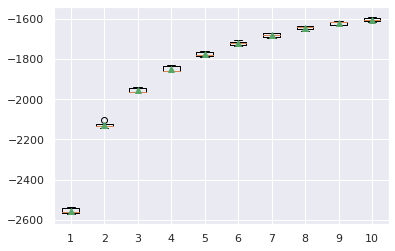

CPU times: user 12min 16s, sys: 5.2 s, total: 12min 21s
Wall time: 12min 27s


In [51]:
%%time

def get_models():  # Функция создания списка экземпляров модели с итерированием гиперпараметра
    models = dict()
    for i in range(1, 11):
        models[str(i)] = LGBMRegressor(max_depth = i, num_leaves = 2**i)
    return models

results, names = results_model()       
plt.boxplot(results, labels=names, showmeans=True) 
plt.show()

##### Скорость обучения

Скорость обучения контролирует степень вклада каждой модели в прогнозирование ансамбля. Меньшие скорости могут потребовать большего количества деревьев решений в ансамбле. Скорость обучения можно контролировать с помощью аргумента learning_rate, по умолчанию она равна 0,1. Исследуем скорость обучения и сравним влияние значений от 0,0001 до 1,0.

>0.0001 -4477.903 (12.090) 79.1
>0.0010 -4207.786 (12.076) 50.5
>0.0100 -2691.990 (15.217) 51.3
>0.1000 -1726.543 (12.258) 57.8
>1.0000 -1782.333 (15.508) 101.1


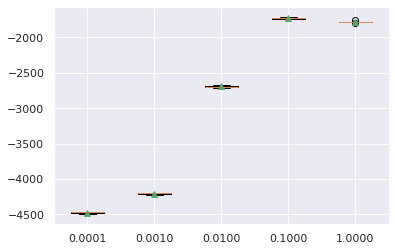

CPU times: user 5min 35s, sys: 2.05 s, total: 5min 37s
Wall time: 5min 40s


In [52]:
%%time

def get_models(): 
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMRegressor(learning_rate=r)
    return models

results, names = results_model() 
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

##### Тип бустинга

Особенность LightGBM — то, что он поддерживает ряд алгоритмов бустинга, называемых типами бустинга. Тип бустинга указывается с помощью аргумента boosting_type и для определения типа принимает строку. Возможные значения:

* ***'gbdt':*** дерево решений с градиеным бустингом (GDBT);
* ***'dart':*** понятие отсева (dropout) ввели в MART и получился DART;
* ***'rf':*** на основе Random Forest;
* ***'goss':*** односторонняя выборка на основе градиента (GOSS).

По умолчанию используется GDBT, классический алгоритм градиентного бустинга.

DART добавляет понятие dropout из глубокого обучения в алгоритм множественных аддитивных регрессионных деревьев (MART), предшественник деревьев решений с градиентным бустингом. Этот алгоритм известен под многими названиями, включая Gradient TreeBoost, Boosted Trees и деревья множественной аддитивной регрессии (MART). Обычно используют последнее название.

GOSS представлен с работой по LightGBM и библиотекой lightbgm. Этот подход направлен на использование только тех экземпляров, которые приводят к большому градиенту ошибки, для обновления модели и удаления остальных экземпляров. Мы исключаем значительную часть экземпляров данных с небольшими градиентами и используем только остальные для оценки прироста информации.

Исследуем три ключевых метода бустинга на наших данных.

>gbdt -1726.543 (12.258) 835.8
>dart -1994.088 (15.102) 141.8
>goss -1723.119 (10.589) 52.4


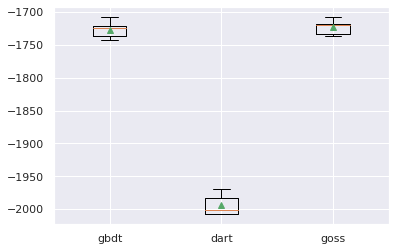

CPU times: user 16min 58s, sys: 4.39 s, total: 17min 2s
Wall time: 17min 10s


In [57]:
%%time

def get_models(): 
    models = dict()
    types = ['gbdt', 'dart', 'goss']
    for t in types:
        models[t] = LGBMRegressor(boosting_type=t)
    return models

results, names = results_model() 
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Проведем тестирование модели с оптимально подобранными гиперпараметрами на тестовой выборке и сравнм результат с лучшей моделью RandomForest и моделью CatBoost без подбора параметров.

In [58]:
%%time

model = RandomForestRegressor(random_state=state, 
                              max_features=0.7, 
                              n_estimators=10).fit(X_train_encoded_oe, y_train)
start_time = time.time()
model.fit(X_train_encoded_oe, y_train)
fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test_encoded_oe)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

RMSE: 1677.450
CPU times: user 29.9 s, sys: 210 ms, total: 30.2 s
Wall time: 31 s


In [ ]:
%%time

models, results_test = [], []
model = LGBMRegressor(n_estimators=1000, 
                      max_depth = 9, 
                      num_leaves = 2**9, 
                      learning_rate = 0.5)

start_time = time.time()
model.fit(X_train_encoded_oe_2, y_train)
fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test_encoded_oe_2)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

In [ ]:
cat_features = ['date_crawled', 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [65]:
%%time

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=1000)

start_time = time.time()
model.fit(train_pool, eval_set=test_pool, verbose=2000, plot=True)
fit_time = time.time() - start_time
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4225.3503304	test: 4231.0528136	best: 4231.0528136 (0)	total: 1.12s	remaining: 18m 38s
999:	learn: 1533.7737613	test: 1606.0777208	best: 1606.0777208 (999)	total: 14m 13s	remaining: 0us

bestTest = 1606.077721
bestIteration = 999

RMSE: 1606.078
CPU times: user 14min 2s, sys: 1.83 s, total: 14min 3s
Wall time: 14min 24s


Проверим результат на константной модели

In [66]:
%%time

start_time = time.time()
y_pred_const = pd.DataFrame(index=range(y_test.shape[0]))
y_pred_const[0] = y_train.mean()
score = mean_squared_error(y_test, y_pred_const, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': 'Dummy', 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

RMSE: 4516.417
CPU times: user 3.96 ms, sys: 4.18 ms, total: 8.15 ms
Wall time: 6.14 ms


In [77]:
results_test = pd.DataFrame(results_test)
results_test.loc[results_test['model_name'] == 'Dummy', ['fit_time', 'predict_time']] = 0.0
results_test.sort_values('rmse')

,model_name,rmse,fit_time,predict_time
2,CatBoostRegressor,1606.1,862.9,864.3
1,RandomForestRegressor,1677.5,15.4,0.6
0,LGBMRegressor,1710.9,266.9,33.2
3,Dummy,4516.4,0.0,0.0


**Выводы**

При исследовании модели градиентного бустинга на наших данных выявлены следующие особенности:
1. Производительность модели растет с увеличением количества деревьев примерно до 500, далее увеличивается незначительно
2. Увеличение производительности модели с глубиной дерева до пяти уровней, после чего производительность остаётся достаточно ровной.
3. Более высокая скорость обучения приводит к лучшей производительности на этом наборе данных, но после 0.1 происходит небольшая потеря качества
4. Метод бустинга по умолчанию и goss работают примерно одинаково по качеству и значительно лучше, чем метод dart.

На тестовой выборке наших данных лучшая модели RandomForest и LightGBM показали примерно одинаковую метрику качества, но первая оказалась значительно быстрее. Модель CatBoost без настройки показала наилучшее качество и приемлемую скорость работы.

Примеры обучения LGBMModel без предварительного кодирования категориальных признаков

In [39]:
cat_features = ['date_crawled', 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [58]:
X_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [55]:
params = {
    'objective': 'regression', 
    'metric': 'rmse'
}

train_data = lgb.Dataset(X_train, y_train, 
                         feature_name=X_train.columns.tolist(), 
                         categorical_feature=cat_features, 
                         free_raw_data=False)

valid_data = lgb.Dataset(X_test, y_test, 
                         feature_name=X_train.columns.tolist(),
                         categorical_feature=cat_features, 
                         free_raw_data=False)

model = lgb.train(params, 
                    train_set=train_data, 
                    valid_sets=valid_data, 
                    verbose_eval=20, 
                    categorical_feature=cat_features, 
                    num_boost_round=100,
                 )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 251595, number of used features: 15
[LightGBM] [Info] Start training from score 4561.194992
[20]	valid_0's rmse: 1993.09
[40]	valid_0's rmse: 1742.84
[60]	valid_0's rmse: 1690.29
[80]	valid_0's rmse: 1667.48
[100]	valid_0's rmse: 1653.46


In [57]:
%%time

model = lgb.LGBMModel(objective='regression', 
                        n_estimators=100,
                        verbose=1,
                        max_depth = 9, 
                        learning_rate = 0.5,)
start_time = time.time()

model.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)], 
            eval_metric='rmse', 
            categorical_feature=cat_features,)

fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 251595, number of used features: 15
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4561.194992
[1]	valid_0's rmse: 3067.68	valid_0's l2: 9.41067e+06
[2]	valid_0's rmse: 2432.02	valid_0's l2: 5.9147e+06
[3]	valid_0's rmse: 2112.87	valid_0's l2: 4.46423e+06
[4]	valid_0's rmse: 1967.64	valid_0'